# Импорты

In [1]:
# %%time
# # здесь будем ставить все, чего нам не хватает
# !pip install missingno -q
# !pip install optuna -q
# !pip install tqdm -q
# !pip install seaborn -q
# !pip install torch -q
# !pip install scikit-learn -q
# !pip install -U scikit-learn -q
# !pip install statsmodels -q
# !pip install shap -q
# !pip install matplotlib -q

In [2]:
# Базовые библиотеки
import sys
import time
import socket
import logging
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# это для сайта, потом удалю
import re
from IPython.display import HTML, display
import missingno as msno

# Работа с базами данных
from sqlalchemy import create_engine, text

# Машинное обучение — модели
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer

# Статистика и интерпретация
import shap

# Sklearn: предобработка, обучение, метрики
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    OrdinalEncoder,
    FunctionTransformer,
    RobustScaler
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    cross_validate
)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)
from sklearn.inspection import permutation_importance

# Оптимизация гиперпараметров
import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Прочее
from tqdm import tqdm

# Настройка логирования
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger(__name__)

# Отключение предупреждений
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=UserWarning, message='Found unknown categories in columns')


e:\my_github\yandex_practicum_ds\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Инструкция по выполнению проекта

## Шаг 1. Загрузите таблицы sql

Подключаемся к базе данных, используя данные:

In [3]:
db_config = {
    "user": "praktikum_student",  # имя пользователя
    "pwd": "Sdf4$2;d-d30pp",  # пароль
    "host": "rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net",
    "port": 6432,  # порт подключения
    "db": "data-science-vehicle-db",  # название базы данных
}


In [4]:
def check_host_availability():
    """Проверка доступности хоста"""
    try:
        socket.create_connection((db_config['host'], db_config['port']), timeout=10)
        logger.info("Хост доступен, можем подключаться и выгружать данные")
        return True
    except socket.error as e:
        logger.info(f"Хост недоступен: {e}")
        sys.exit("ОСТАНОВКА: Не удалось подключиться к базе данных. Дальнейшее выполнение невозможно.")

check_host_availability()

2025-12-05 16:52:52 [INFO] __main__: Хост доступен, можем подключаться и выгружать данные


True

## Шаг 2. Проведите первичное исследование таблиц

### Все ли таблицы имеют набор данных

In [5]:
connection_string = f"postgresql://{db_config['user']}:{db_config['pwd']}@{db_config['host']}:{db_config['port']}/{db_config['db']}"
engine = create_engine(connection_string)

def list_all_tables(engine):
    """
    Показывает все таблицы в базе данных
    """
    query = text("""
    SELECT table_name 
    FROM information_schema.tables 
    WHERE table_schema = 'public'
    ORDER BY table_name
    """)
    
    with engine.connect() as conn:
        result = conn.execute(query)
        all_tables = [row[0] for row in result]
    
    logger.info("Все таблицы в базе данных:")
    for table in all_tables:
        logger.info(f" - {table}")
    
    return all_tables

# Просмотр всех таблиц
all_tables = list_all_tables(engine)

2025-12-05 16:52:52 [INFO] __main__: Все таблицы в базе данных:
2025-12-05 16:52:52 [INFO] __main__:  - case_ids
2025-12-05 16:52:52 [INFO] __main__:  - collisions
2025-12-05 16:52:52 [INFO] __main__:  - parties
2025-12-05 16:52:52 [INFO] __main__:  - vehicles


В базе присутствуют все указанные имебщиеся в ТЗ таблицы, посмотрим их немного детальнее

### Имеется ли общий ключ для связи таблиц

In [6]:
def check_tables(engine):
    for table in ['case_ids', 'collisions', 'parties', 'vehicles']:
        logger.info(f"\n{table}:")
        df = pd.read_sql_query(f"SELECT * FROM {table} LIMIT 5", engine)
        display(df)

check_tables(engine)

2025-12-05 16:52:52 [INFO] __main__: 
case_ids:


,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


2025-12-05 16:52:52 [INFO] __main__: 
collisions:


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


2025-12-05 16:52:52 [INFO] __main__: 
parties:


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


2025-12-05 16:52:52 [INFO] __main__: 
vehicles:


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


case_ids нам не пригодтся, все данные есть в других таблицах  
в остальных таблицах везде есть общий ключ case_id  
для таблиц parties и vehicles также надо использовать и второй общий ключ - party_number

# Шаг 3. Проведите статистический анализ факторов ДТП

## Выясните, в какие месяцы происходит наибольшее количество аварий. Проанализируйте весь период наблюдений (таблица collisions).

### Создайте sql-запрос

In [7]:
def get_month_crash(engine):
    for table in ['collisions']:
        query = """
        SELECT 
            DATE_TRUNC('month', collision_date) as month,
            COUNT(*) as count
        FROM collisions
        GROUP BY DATE_TRUNC('month', collision_date)
        ORDER BY month
        """
        
        monthly_counts = pd.read_sql_query(query, engine)
        logger.info(f"Количество записей по месяцам:")
        display(monthly_counts)
        return monthly_counts

monthly_counts = get_month_crash(engine)

2025-12-05 16:52:53 [INFO] __main__: Количество записей по месяцам:


,month,count
0,2009-01-01 00:00:00+03:00,35062
1,2009-02-01 00:00:00+03:00,34480
2,2009-03-01 00:00:00+03:00,36648
3,2009-04-01 00:00:00+04:00,35239
4,2009-05-01 00:00:00+04:00,36916
5,2009-06-01 00:00:00+04:00,34202
6,2009-07-01 00:00:00+04:00,35161
7,2009-08-01 00:00:00+04:00,34508
8,2009-09-01 00:00:00+04:00,35555
9,2009-10-01 00:00:00+04:00,37835


### Постройте график

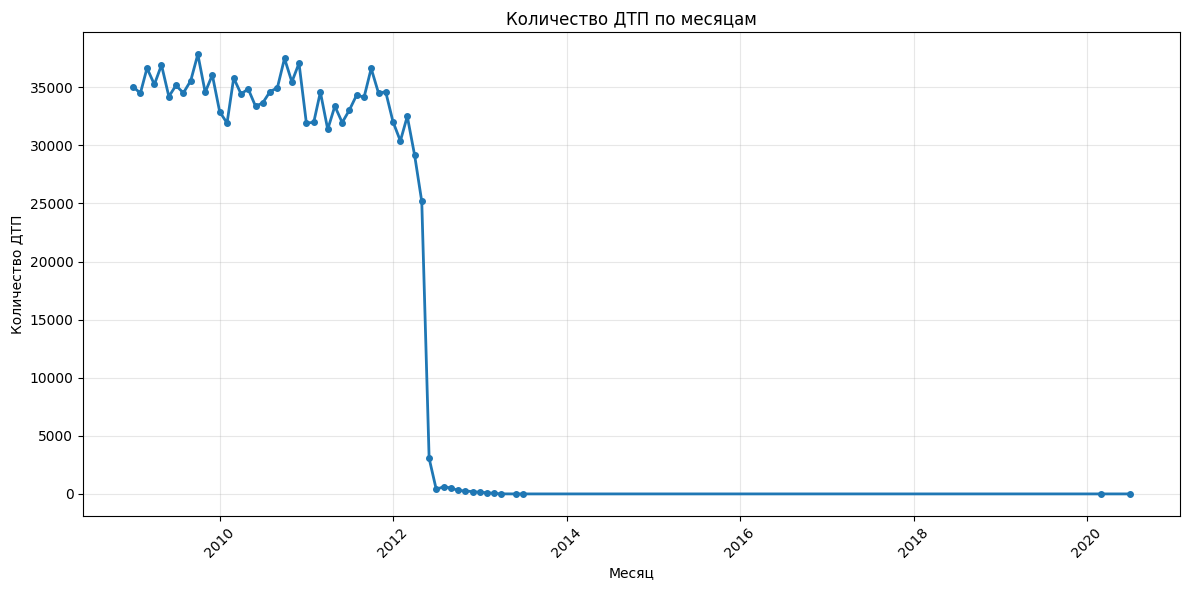

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_counts['month'], monthly_counts['count'], marker='o', linewidth=2, markersize=4)
plt.title('Количество ДТП по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество ДТП')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Здесь явно прослеживается проблема с отгрузкой данных в базу после мая 2012 года

# Создать аналитические задачи и поручить их решение коллегам

### Пропишите порядок решения для двух задач из списка. Реализуйте его.

#### 1) Оценить влияние погоды (weather_1) на вероятность ДТП по вине водителя, только в данных до мая 2012

In [9]:
def weather_crash(engine):
    query = """
    SELECT 
        c.weather_1,
        p.at_fault,
        COUNT(*) AS cnt
    FROM collisions c
    JOIN parties p ON c.case_id = p.case_id
    JOIN vehicles v ON c.case_id = v.case_id AND p.party_number = v.party_number
    WHERE c.collision_date < '2012-05-01'
    GROUP BY c.weather_1, p.at_fault
    ORDER BY cnt DESC
    """
    
    weather_crash_res = pd.read_sql_query(query, engine)
    display(weather_crash_res)
    return weather_crash_res

weather_crash_res = weather_crash(engine)

,weather_1,at_fault,cnt
0,clear,0,457494
1,clear,1,348991
2,cloudy,0,75653
3,cloudy,1,65954
4,raining,0,19689
5,raining,1,18211
6,None,0,3101
7,fog,1,2018
8,fog,0,1731
9,None,1,1489


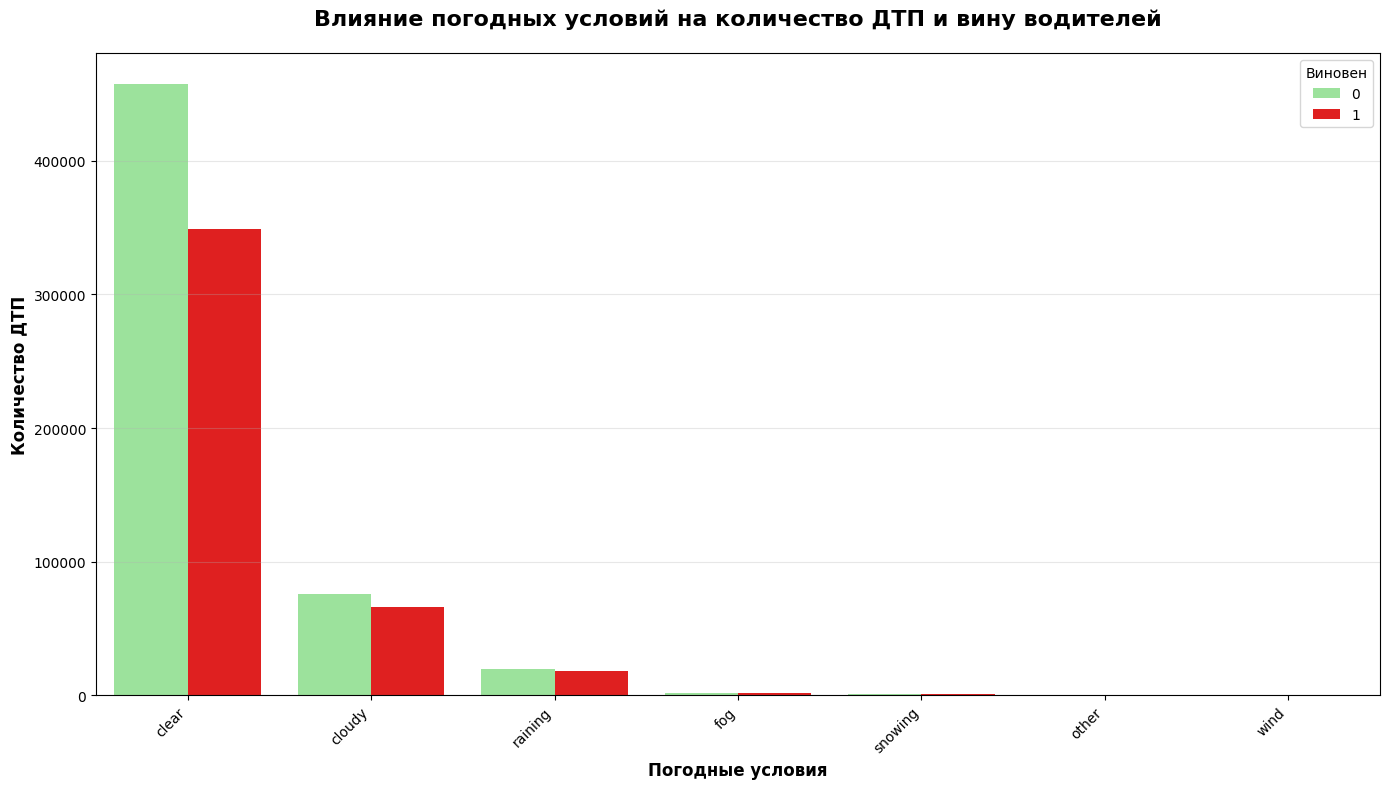

In [10]:
plt.figure(figsize=(14, 8))

sns.barplot(data=weather_crash_res, x='weather_1', y='cnt', hue='at_fault', 
            palette={0: 'lightgreen', 1: 'red'})

plt.title('Влияние погодных условий на количество ДТП и вину водителей', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Погодные условия', fontsize=12, fontweight='bold')
plt.ylabel('Количество ДТП', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Виновен')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

##### Выводы

Как видим из графика - основная масса дтп происходит в ясную погоду

#### 2) Проанализировать зависимость риска ДТП от возраста автомобиля (vehicle_age)

In [11]:
def old_cars_crash(engine):
    query = """
    SELECT 
        v.vehicle_age,
        p.at_fault,
        COUNT(*) AS cnt
    FROM collisions c
    JOIN parties p ON c.case_id = p.case_id
    JOIN vehicles v ON c.case_id = v.case_id AND p.party_number = v.party_number
    WHERE c.collision_date < '2012-05-01'
    GROUP BY v.vehicle_age, p.at_fault
    ORDER BY v.vehicle_age
    """
    
    old_cars_crash = pd.read_sql_query(query, engine)
    display(old_cars_crash)
    return old_cars_crash

old_cars_crash = old_cars_crash(engine)

,vehicle_age,at_fault,cnt
0,0.0,0,21660
1,0.0,1,17636
2,1.0,0,22477
3,1.0,1,17982
4,2.0,0,47224
5,2.0,1,57132
6,3.0,0,79371
7,3.0,1,94914
8,4.0,0,67419
9,4.0,1,54981


2025-12-05 16:52:51 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-05 16:52:51 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


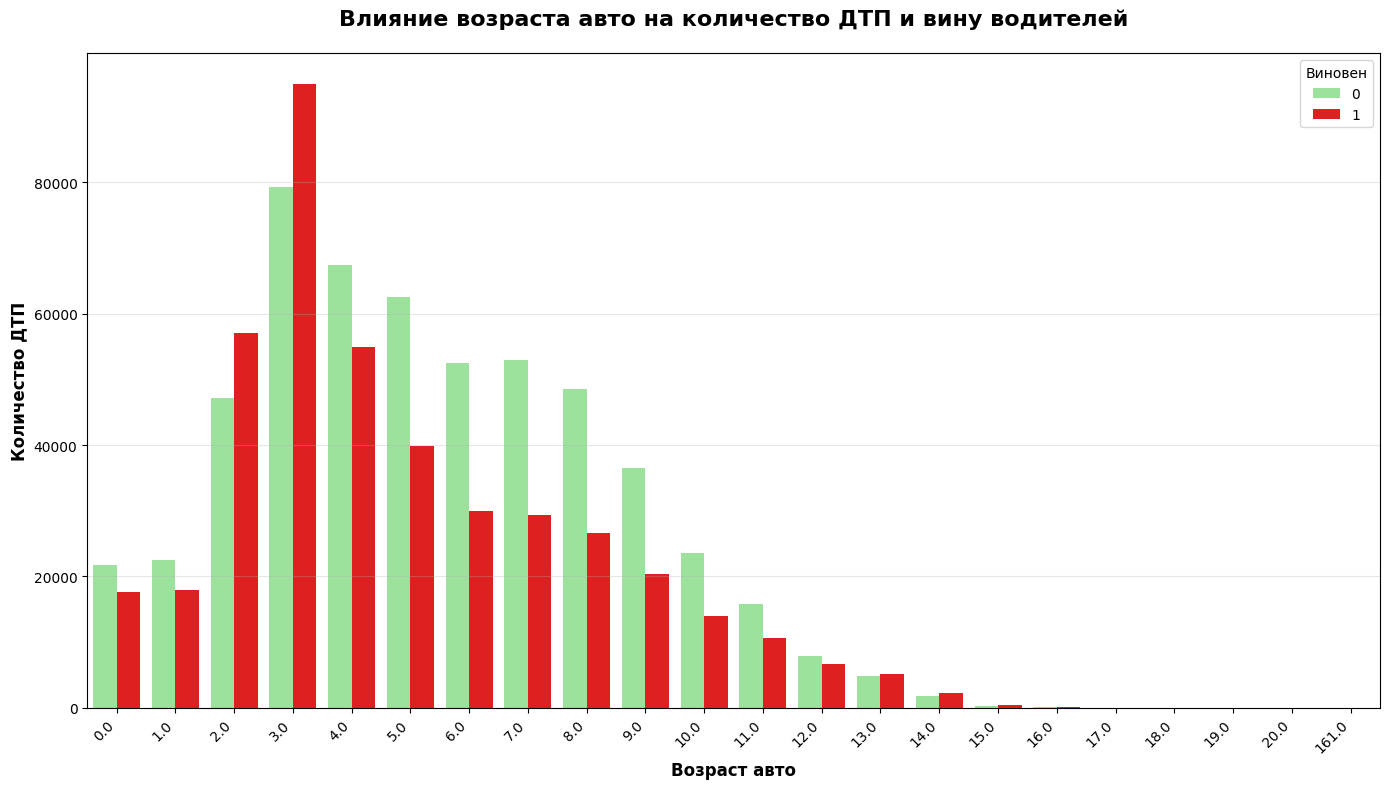

In [12]:
plt.figure(figsize=(14, 8))

sns.barplot(data=old_cars_crash, x='vehicle_age', y='cnt', hue='at_fault', 
            palette={0: 'lightgreen', 1: 'red'})

plt.title('Влияние возраста авто на количество ДТП и вину водителей', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Возраст авто', fontsize=12, fontweight='bold')
plt.ylabel('Количество ДТП', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Виновен')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

##### Выводы

В целом возраст автомобиля также не влияет на риск ДТП, есть конечно же всплеск у 3х леток, возможно влияет выход из строя основных узлов, учитывая большой и быстро растущий пробег.

## Еще 4 задачи

1. Проанализировать, как состояние покрытия дороги влияет на вероятность ДТП  
Использовать: road_surface, at_fault.  

2. Оценить связь типа трансмиссии с вероятностью быть виновником  
Использовать: vehicle_transmission, at_fault.  

3. Найти влияние освещённости (lighting) на риск ДТП по вине водителя  
Использовать: lighting, at_fault.  

4. Проанализировать влияние использования телефона на вероятность виновности  
Использовать: cellphone_in_use, at_fault.  

# Шаг 4. Создайте модель для оценки водительского риска

## Подготовьте набор данных на основе первичного предположения заказчика

Выберите тип виновника — только машина (car).  
Возьмите случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).  
Для моделирования возьмите данные только за 2012 год.  
Подготовка исходной таблицы должна проводиться с помощью sql-запроса.  

In [13]:
logger.info("=== ЗАГРУЗКА ОТФИЛЬТРОВАННЫХ ТАБЛИЦ ===")

# оптимизированные запросы с учетом отбора признаков
query = """
SELECT 
    -- Из collisions
    -- c.case_id,
    c.weather_1,
    c.road_surface,
    c.lighting,
    c.intersection,
    c.location_type,
    c.pcf_violation_category,
    c.type_of_collision,
    c.road_condition_1,
    c.direction,
    -- c.distance,
    c.collision_date::date,
    c.collision_time::time,
    c.county_city_location,
    c.county_location,
    c.control_device,
    
    -- Из parties
    p.party_number,
    p.at_fault,
    p.party_sobriety,
    p.cellphone_in_use,
    p.insurance_premium,
    
    -- Из vehicles
    v.vehicle_type,
    v.vehicle_age,
    v.vehicle_transmission
    
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
JOIN vehicles v ON c.case_id = v.case_id AND p.party_number = v.party_number
WHERE c.collision_date < '2012-12-31'
-- WHERE c.collision_date < '2012-01-01'
    AND  c.collision_date > '2008-12-31'
    AND c.collision_damage <> 'scratch'
    AND p.party_type = 'car'
    AND v.vehicle_age < 11
"""

filtered_tables_config = {
    'df': query
}

2025-12-05 16:52:51 [INFO] __main__: === ЗАГРУЗКА ОТФИЛЬТРОВАННЫХ ТАБЛИЦ ===


In [14]:
def load_data_safe(engine, table_name_or_query, use_chunks=True, chunksize=300000):
    """Загружает данные - либо таблицу целиком, либо по SQL-запросу"""
    try:
        if isinstance(table_name_or_query, str) and table_name_or_query.strip().upper().startswith('SELECT'):
            logger.info(f"Загружаем данные по SQL-запросу...")
            result = pd.read_sql(table_name_or_query, engine)
            logger.info(f"Загружено: {result.shape[0]} строк, {result.shape[1]} столбцов")
            return result
        else:
            table_name = table_name_or_query
            if use_chunks:
                logger.info(f"Загружаем таблицу {table_name} по частям...")
                count_query = f"SELECT COUNT(*) FROM {table_name}"
                total_rows = pd.read_sql(count_query, engine).iloc[0,0]
                logger.info(f"Всего строк в {table_name}: {total_rows}")
                
                chunks = []
                for offset in range(0, total_rows, chunksize):
                    query = f"SELECT * FROM {table_name} LIMIT {chunksize} OFFSET {offset}"
                    chunk = pd.read_sql(query, engine)
                    chunks.append(chunk)
                    logger.info(f"Загружено {len(chunk)} строк (прогресс: {min(offset + chunksize, total_rows)}/{total_rows})")
                
                result = pd.concat(chunks, ignore_index=True)
                logger.info(f"{table_name}: {result.shape[0]} строк, {result.shape[1]} столбцов")
                return result
            else:
                logger.info(f"Загружаем таблицу {table_name}...")
                result = pd.read_sql(f"SELECT * FROM {table_name}", engine)
                logger.info(f"{table_name}: {result.shape[0]} строк, {result.shape[1]} столбцов")
                return result
        
    except Exception as e:
        logger.error(f"Ошибка при загрузке: {e}")
        return None

def load_all_tables_safe(engine, tables_config):
    """Безопасная загрузка всех таблиц/запросов"""
    dataframes = {}
    
    for table_name, table_ref in tables_config.items():
        dataframes[table_name] = load_data_safe(engine, table_ref)
    
    return dataframes

In [15]:
df_dict_filtered = load_all_tables_safe(engine, filtered_tables_config)
successful_tables = {k: v for k, v in df_dict_filtered.items() if v is not None}

if len(successful_tables) == len(filtered_tables_config):
    df = df_dict_filtered['df']
    
    logger.info("Все отфильтрованные данные успешно загружены и готовы к анализу.")
    
else:
    logger.warning(f"Загружены не все таблицы. Успешно: {list(successful_tables.keys())}")
    
    if 'df' in successful_tables:
        df = df_dict_filtered['df']

2025-12-05 16:52:51 [INFO] __main__: Загружаем данные по SQL-запросу...
2025-12-05 16:53:07 [INFO] __main__: Загружено: 460623 строк, 22 столбцов
2025-12-05 16:53:07 [INFO] __main__: Все отфильтрованные данные успешно загружены и готовы к анализу.


## Отбор признаков для модели предсказания виновности в ДТП

### Признаки для модели

Из таблицы `collisions`

| Признак | Описание |
|---------|-------------|
| `WEATHER_1` | Погодные условия напрямую влияют на видимость и управляемость транспортным средством |
| `ROAD_SURFACE` | Состояние дорожного покрытия значительно воздействует на риск возникновения ДТП |
| `LIGHTING` | Уровень освещённости влияет на видимость и скорость реакции водителя |
| `INTERSECTION` | Перекрестки являются зонами повышенной аварийности и сложности манёвров |
| `LOCATION_TYPE` | Тип дороги определяет характер движения и потенциальные риски |
| `COUNTY_CITY_LOCATION` | Без детальных карт и анализа дорожной инфраструктуры сложно интерпретировать |
| `COUNTY_LOCATION` | Географическая привязка без контекста дорожных условий |
| `ROAD_CONDITION_1` | Дополнительные дорожные условия создают дополнительные факторы риска |
| `DIRECTION` | Направление движения само по себе не является информативным признаком, но пусть будет |
| `CONTROL_DEVICE` | В описании данных признака нет, но судя по всему речь о светофорах и другим устройствам контроля движения |

Из таблицы `parties`

| Признак | Описание |
|---------|-------------|
| `CELLPHONE_IN_USE` | Использование телефона за рулём приводит к отвлечению внимания и нарушениям |
 `INSURANCE_PREMIUM` | Тут тонкий момент, если это именно страхова премия, а не возмещение, то ок, можно использовать в работе |

Из таблицы `vehicles`

| Признак | Описание |
|---------|-------------|
| `VEHICLE_AGE` | Обязателен по ТЗ - возраст автомобиля может влиять на техническую исправность и безопасность |
| `VEHICLE_TYPE` | Тип кузова может влиять на управляемость и поведение транспортного средства |

---

### Таблица признаков для исключения

| Категория | Признак | Причина исключения |
|-----------|---------|-------------------|
| **Признаки-утечки** | `PARTY_SOBRIETY` | Состояние трезвости является ключевым фактором определения виновника |
| | `PCF_VIOLATION_CATEGORY` | Категории нарушений ПДД напрямую коррелируют с виновностью |
| | `TYPE_OF_COLLISION` | Тип столкновения может указывать на действия виновника аварии |
| | `PARTY_DRUG_PHYSICAL` | Физическое состояние водителя напрямую влияет на виновность |
| | `PARTY_NUMBER` | Технический номер участника в рамках ДТП |
| | `PARTY_COUNT` | Количество участников ДТП слабо коррелирует с виновностью конкретного водителя |
| | `MOTOR_VEHICLE_INVOLVED_WITH` | Тип второго участника менее важен, чем действия самого виновника |
| | `DISTANCE` | Расстояние от главной дороги без дополнительного контекста не информативно |
| **Технические идентификаторы** | `CASE_ID` | Уникальный идентификатор, не несет прогнозной способности |
| | `ID` | Уникальный идентификатор случая |
| **Временные признаки** | `COLLISION_DATE` | Рекомендуется вынести в отдельный анализ сезонности |
| | `COLLISION_TIME` | Будет преобразован в циклические признаки (час, день недели) |
| **Избыточные признаки** | `PRIMARY_COLLISION_FACTOR` | Дублирует информацию из `PCF_VIOLATION_CATEGORY` |


### Рекомендации по преобразованию признаков

#### Временные признаки для преобразования:
- **`COLLISION_DATE`** ->  месяц, день недели, сезон
- **`COLLISION_TIME`** -> час (с циклическим кодированием)

#### Признаки для дальнейшего анализа:
- Географические признаки могут быть полезны при наличии дополнительных данных о дорожной инфраструктуре
- Временные признаки после преобразования станут ценным источником информации о сезонности и временных паттернах ДТП

In [16]:
# функции из файла func.py которые используются в проекте - это для сайта, потом удалю
# форматирования текста
def format_display(text):
    return HTML(
        f"<span style='font-size: 1.5em; font-weight: bold; font-style: italic;'>{text}</span>"
    )


# сделаем функцию оценки пропусков в датасетах
def missing_data(data):
    missing_data = data.isna().sum()
    missing_data = missing_data[missing_data > 0]
    display(missing_data)


# функция для обработки пробелов
def process_spaces(s):
    if isinstance(s, str):
        s = s.strip()
        s = " ".join(s.split())
    return s


# замена пробелов на нижнее подчеркинвание в названии столбцов
def replace_spaces(s):
    if isinstance(s, str):
        s = s.strip()
        s = "_".join(s.split())
    return s


def drop_duplicated(data):
    # проверка дубликатов
    display(format_display("Проверим дубликаты и удалим, если есть"))
    num_duplicates = data.duplicated().sum()
    display(num_duplicates)

    if num_duplicates > 0:
        display("Удаляем")
        data = data.drop_duplicates(keep="first").reset_index(
            drop=True
        )  # обновляем DataFrame
    else:
        display("Дубликаты отсутствуют")
    return data


def normalize_columns(columns):
    new_cols = []
    for col in columns:
        # вставляем "_" перед заглавной буквой (латиница или кириллица), кроме первой
        col = re.sub(r"(?<!^)(?=[A-ZА-ЯЁ])", "_", col)
        # приводим к нижнему регистру
        col = col.lower()
        new_cols.append(col)
    return new_cols


def check_data(data):
    # приведем все к нижнему регистру
    data.columns = normalize_columns(data.columns)

    # удалим лишние пробелы в строках
    for col in data.columns:
        if data[col].dtype == "object":
            data[col] = data[col].apply(
                lambda x: process_spaces(x) if isinstance(x, str) else x
            )

    # и в названии столбцов
    data.columns = [replace_spaces(col) for col in data.columns]

    # строки в ячейках строчными буквами
    for col in data.columns:
        if data[col].dtype == "object":
            # Безопасное преобразование: только для строк, игнорируем None и не-строки
            data[col] = data[col].apply(
                lambda x: x.lower() if isinstance(x, str) else x
            )

    # общая информация
    display(format_display("Общая информация базы данных"))
    display(data.info())

    # 5 строк
    display(format_display("5 случайных строк"))
    display(data.sample(5))

    # пропуски
    display(format_display("Число пропусков в базе данных"))
    display(missing_data(data))

    # проверка на наличие пропусков
    if data.isnull().sum().sum() > 0:
        display(format_display("Визуализация пропусков"))
        msno.bar(data)
        plt.show()

    # средние характеристики
    display(format_display("Характеристики базы данных"))
    display(data.describe().T)

    # data = drop_duplicated(data)

    return data  # возвращаем измененные данные


def plot_combined(data, col=None, target=None, col_type=None, legend_loc="best"):
    """
    Строит графики для числовых столбцов в DataFrame, автоматически определяя их типы (дискретные или непрерывные).

    :param data: DataFrame, содержащий данные для визуализации.
    :param col: Список столбцов для построения графиков. Если None, будут использованы все числовые столбцы.
    :param target: Столбец, по которому будет производиться разделение (для hue в графиках).
    :param col_type: Словарь, определяющий типы столбцов ('col' для непрерывных и 'dis' для дискретных).
                     Если None, типы будут определены автоматически.
    :param legend_loc: Положение легенды для графиков (по умолчанию 'best').
    :return: None. Графики отображаются с помощью plt.show().
    """

    # Определяем числовые столбцы
    if col is None:
        numerical_columns = data.select_dtypes(
            include=["int", "float"]
        ).columns.tolist()
    else:
        numerical_columns = col

    # Если col_type не указан, определяем типы автоматически
    if col_type is None:
        col_type = {}
        for col in numerical_columns:
            unique_count = data[col].nunique()
            if unique_count > 20:
                col_type[col] = "col"  # Непрерывные данные
            else:
                col_type[col] = "dis"  # Дискретные данные

    total_plots = len(numerical_columns) * 2
    ncols = 2
    nrows = (total_plots + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows))
    axs = axs.flatten()

    index = 0

    for col in numerical_columns:
        # Определяем тип графика
        plot_type = col_type.get(col)
        if plot_type is None:
            raise ValueError(f"Тип для столбца '{col}' не указан в col_type.")

        # Гистограмма или countplot
        if index < len(axs):
            if plot_type == "col":
                if target is not None:
                    sns.histplot(
                        data, x=col, hue=target, bins=20, kde=True, ax=axs[index]
                    )
                    handles, labels = axs[index].get_legend_handles_labels()
                    if handles:
                        axs[index].legend(title=target, loc=legend_loc)
                else:
                    sns.histplot(data[col].dropna(), bins=20, kde=True, ax=axs[index])
                axs[index].set_title(f"Гистограмма: {col}")
            elif plot_type == "dis":
                if target is not None:
                    sns.countplot(data=data, x=col, hue=target, ax=axs[index])
                    handles, labels = axs[index].get_legend_handles_labels()
                    if handles:
                        axs[index].legend(title=target, loc=legend_loc)
                else:
                    sns.countplot(data=data, x=col, ax=axs[index])
                axs[index].set_title(f"Countplot: {col}")
                # поворот подписей X для дискретных
                axs[index].tick_params(axis="x", rotation=90)
            index += 1

        # Боксплот
        if index < len(axs):
            sns.boxplot(x=data[col], ax=axs[index])
            axs[index].set_title(f"Боксплот: {col}")
            # тоже поворачиваем, если дискретные значения
            if plot_type == "dis":
                axs[index].tick_params(axis="x", rotation=90)
            index += 1

    # Отключаем оставшиеся оси
    for j in range(index, len(axs)):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()


def calc_target_correlations(df, target_col: str = None, drop_cols: list = None, 
                           discrete_max_unique: int = 10):  # type: ignore
    """
    Считает корреляции признаков с таргетом, строит heatmap и рассчитывает VIF.
    Использует только непрерывные признаки для корреляции.
    
    Parameters:
    -----------
    discrete_max_unique : int
        Максимальное количество уникальных значений для признака, 
        чтобы считать его дискретным (не непрерывным). По умолчанию 10.
    """
    if drop_cols is None:
        drop_cols = []

    df_tmp = df.copy()

    cat_cols = df_tmp.select_dtypes(include=["object", "category"]).columns
    for c in cat_cols:
        df_tmp[c] = df_tmp[c].astype("category").cat.codes

    numeric_cols = df_tmp.select_dtypes(exclude=["object", "category"]).columns.tolist()
    
    if target_col not in numeric_cols:
        raise ValueError(f"target_col '{target_col}' должен быть числовым")

    continuous_cols = []
    discrete_cols = []
    
    for col in numeric_cols:
        if col == target_col:
            continuous_cols.append(col)
            continue
            
        unique_count = df_tmp[col].nunique()
        if unique_count > discrete_max_unique:
            continuous_cols.append(col)
        else:
            discrete_cols.append(col)
    
    logger.info("=== Дискретные признаки (исключены из корреляции) ===")
    if discrete_cols:
        display(", ".join(discrete_cols))
    else:
        logger.info("Дискретные признаки не найдены")
    
    logger.info("\n=== Непрерывные признаки (используются для корреляции) ===")
    display(", ".join([c for c in continuous_cols if c != target_col]))

    corr_df = (
        df_tmp[continuous_cols]
        .corr()[target_col]
        .drop(target_col)
        .sort_values(key=np.abs, ascending=False)
    )
    logger.info("\n=== Корреляция непрерывных признаков с таргетом ===")
    display(corr_df)

    heatmap_cols = [
        col for col in continuous_cols 
        if col not in drop_cols or col == target_col
    ]
    corr_matrix = df_tmp[heatmap_cols].corr()

    plt.figure(figsize=(12, 10))
    plt.imshow(corr_matrix, interpolation="nearest", cmap="coolwarm", aspect="auto")
    plt.xticks(
        range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90, fontsize=8
    )
    plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns, fontsize=8)
    plt.colorbar()
    plt.title(f"Correlation Heatmap (только непрерывные признаки, target={target_col})")

    for i in range(corr_matrix.shape[0]):
        for j in range(corr_matrix.shape[1]):
            value = corr_matrix.iloc[i, j]
            plt.text(
                j,
                i,
                f"{value:.2f}",
                ha="center",
                va="center",
                fontsize=10,
                color="black",
            )

    plt.tight_layout()
    plt.show()

    vif_cols = [
        col for col in continuous_cols 
        if col != target_col and col not in drop_cols
    ]
    
    if vif_cols:
        X_vif = df_tmp[vif_cols].copy()
        scaler = RobustScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X_vif), columns=vif_cols)

        vif_data = pd.DataFrame()
        vif_data["feature"] = vif_cols
        vif_data["VIF"] = [
            variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])
        ]
        vif_data = vif_data.sort_values("VIF", ascending=False)

        logger.info("=== VIF (только непрерывные признаки) ===")
        display(vif_data)
    else:
        logger.info("=== Нет непрерывных признаков для расчета VIF ===")

In [17]:
def plot_categorical_columns(data, col=None, target=None, top_n=None):
    """
    Визуализация категориальных столбцов: только столбчатые графики (с группировкой по target).
    top_n — показывать только top_n категорий, остальные сворачивать в 'other'.
    """
    categorical_columns = data.select_dtypes(
        include=["object", "category"]
    ).columns.tolist()

    if col is not None:
        if col not in data.columns:
            print(f"Столбец '{col}' не найден в DataFrame.")
            return
        categorical_columns = [col]

    if len(categorical_columns) == 0:
        print("Категориальных столбцов нет.")
        return

    n = len(categorical_columns)
    ncols = 2
    nrows = (n + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows))
    if isinstance(axs, np.ndarray):
        axs = axs.flatten()
    else:
        axs = [axs]

    idx = 0
    for c in categorical_columns:
        # Создаем копию данных для обработки top_n
        plot_data = data.copy()

        if top_n is not None:
            top_categories = plot_data[c].value_counts().head(top_n).index
            plot_data[c] = plot_data[c].apply(
                lambda x: x if x in top_categories else "other"
            )

        vc = plot_data[c].fillna("NaN").value_counts()

        labels = vc.index.tolist()
        
        cmap = plt.cm.get_cmap("tab20", len(labels))
        colors = [cmap(i) for i in range(len(labels))]

        if target is not None and target in plot_data.columns:
            grouped = plot_data.groupby([target, c]).size().unstack(fill_value=0)
            cmap2 = plt.cm.get_cmap("tab20", len(grouped.columns))
            bar_colors = [cmap2(i) for i in range(len(grouped.columns))]
            grouped.plot(kind="bar", ax=axs[idx], color=bar_colors)
            axs[idx].legend(title=target)
        else:
            vc.plot(kind="bar", ax=axs[idx], color=colors)

        axs[idx].set_title(f"{c} (гистограмма)")
        axs[idx].set_ylabel("Частота")
        axs[idx].tick_params(axis="x", rotation=90)
        idx += 1

    for j in range(idx, len(axs)):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()

### Статистическое исследование отобранных факторов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460623 entries, 0 to 460622
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   weather_1               458750 non-null  object 
 1   road_surface            457269 non-null  object 
 2   lighting                458484 non-null  object 
 3   intersection            458622 non-null  float64
 4   location_type           212101 non-null  object 
 5   pcf_violation_category  455059 non-null  object 
 6   type_of_collision       457986 non-null  object 
 7   road_condition_1        457555 non-null  object 
 8   direction               353531 non-null  object 
 9   collision_date          460623 non-null  object 
 10  collision_time          459992 non-null  object 
 11  county_city_location    460623 non-null  object 
 12  county_location         460623 non-null  object 
 13  control_device          458820 non-null  object 
 14  party_number        

None

,weather_1,road_surface,lighting,intersection,location_type,pcf_violation_category,type_of_collision,road_condition_1,direction,collision_date,...,county_location,control_device,party_number,at_fault,party_sobriety,cellphone_in_use,insurance_premium,vehicle_type,vehicle_age,vehicle_transmission
301314,clear,None,daylight,0.0,None,unsafe lane change,sideswipe,holes,north,2011-04-23,...,riverside,none,1,1,had not been drinking,0.0,25.0,sedan,3,manual
345831,cloudy,dry,daylight,1.0,None,automobile right of way,broadside,normal,None,2011-10-21,...,los angeles,none,2,0,had not been drinking,0.0,27.0,coupe,4,auto
257755,clear,dry,daylight,0.0,None,improper turning,overturned,normal,west,2010-09-20,...,fresno,none,1,1,had not been drinking,0.0,19.0,coupe,3,manual
253327,raining,wet,dark with no street lights,0.0,highway,speeding,broadside,normal,north,2009-02-12,...,kern,none,1,1,had not been drinking,0.0,22.0,coupe,3,auto
117175,clear,dry,daylight,1.0,None,traffic signals and signs,head-on,normal,None,2010-09-27,...,los angeles,functioning,1,1,had not been drinking,0.0,42.0,coupe,6,auto


weather_1                   1873
road_surface                3354
lighting                    2139
intersection                2001
location_type             248522
pcf_violation_category      5564
type_of_collision           2637
road_condition_1            3068
direction                 107092
collision_time               631
control_device              1803
party_sobriety              6894
cellphone_in_use           40908
insurance_premium           4007
vehicle_transmission        4829
dtype: int64

None

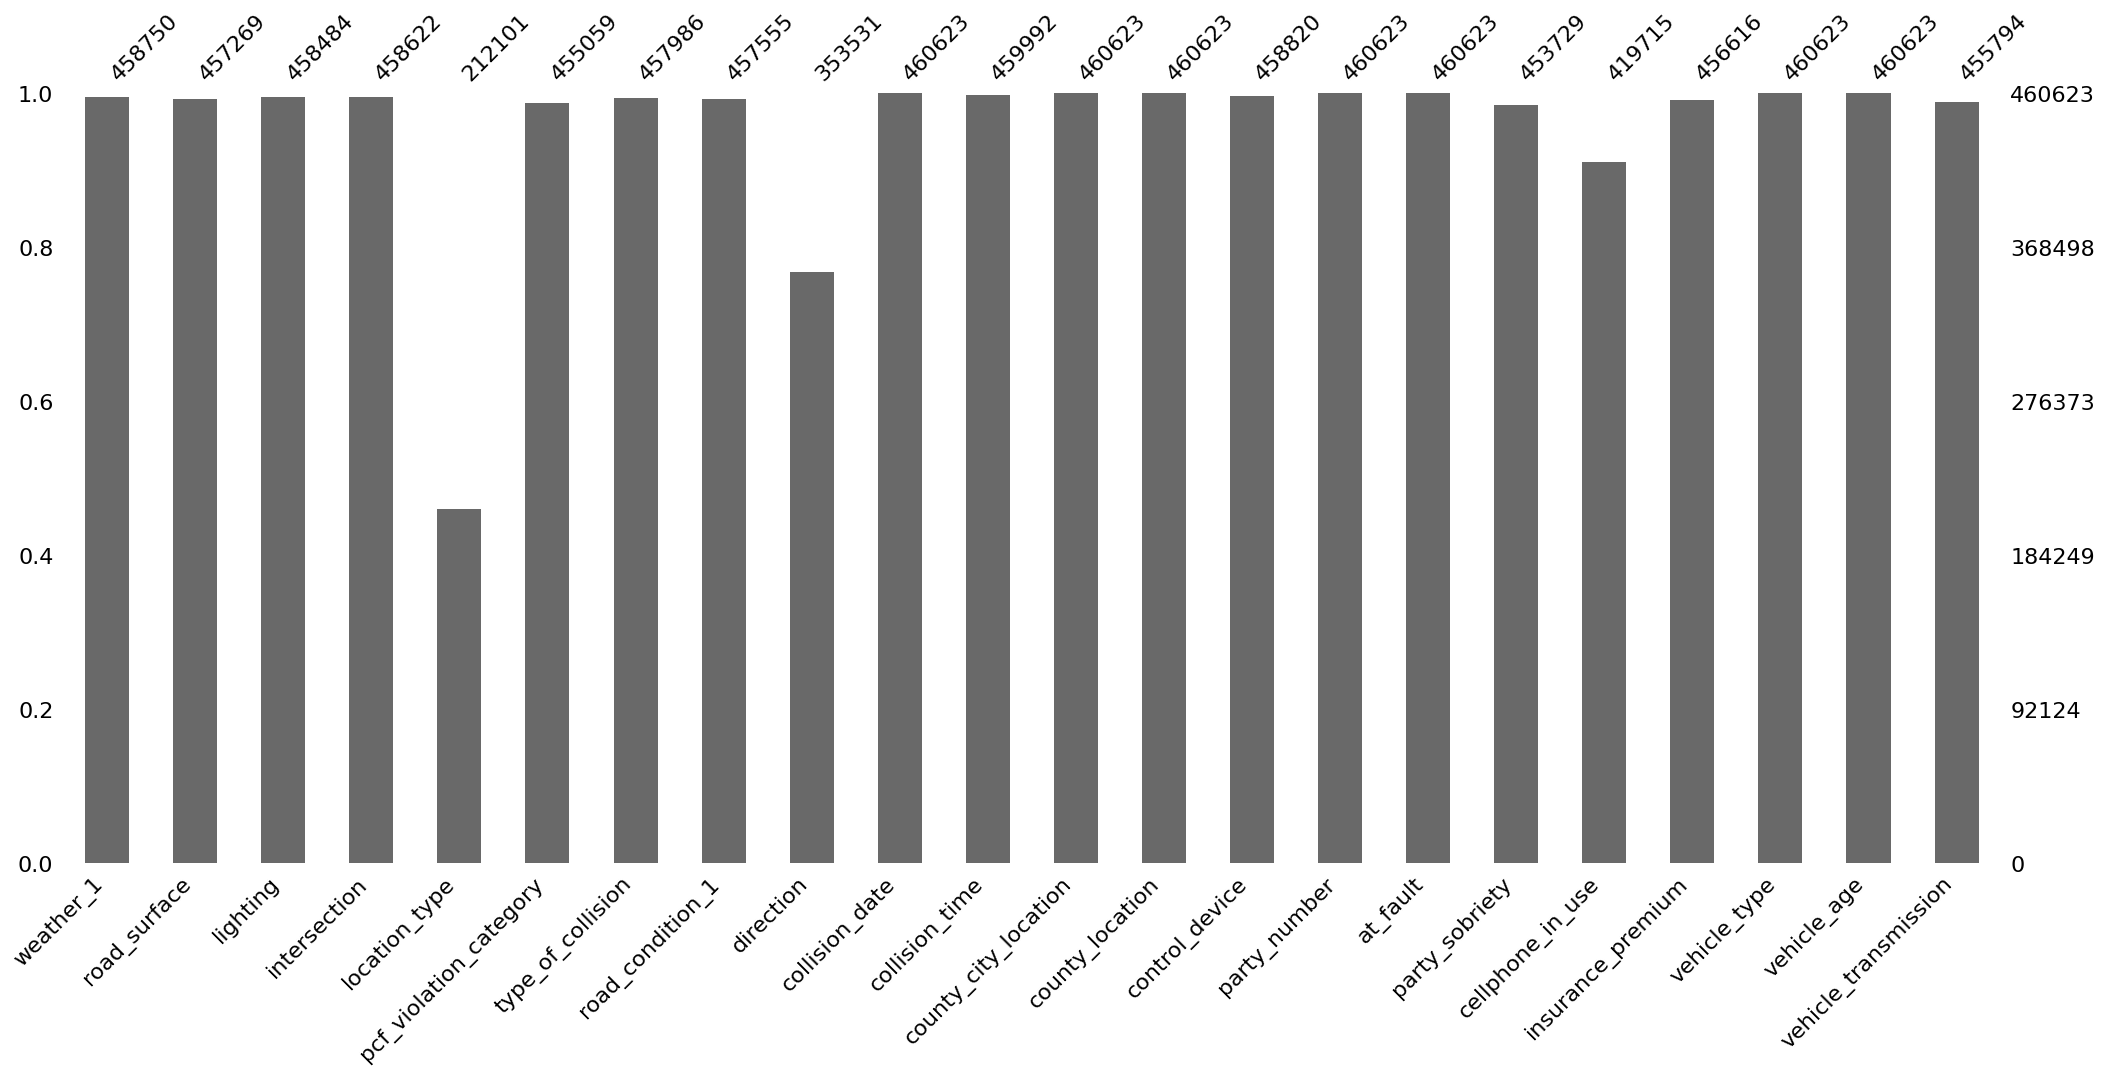

,count,mean,std,min,25%,50%,75%,max
intersection,458622.0,0.222320,0.415806,0.0,0.0,0.0,0.0,1.0
party_number,460623.0,1.526546,0.663029,1.0,1.0,1.0,2.0,13.0
at_fault,460623.0,0.499719,0.500000,0.0,0.0,0.0,1.0,1.0
cellphone_in_use,419715.0,0.019211,0.137265,0.0,0.0,0.0,0.0,1.0
insurance_premium,456616.0,35.416470,14.241635,0.0,23.0,33.0,46.0,105.0
vehicle_age,460623.0,4.356843,2.592554,0.0,3.0,4.0,6.0,10.0


In [18]:
df = check_data(df)

1) Первое что бросается в глаза - много пропусков, но сделать мы с ними ничего не можем, поэтому заполним их как unknown  
2) У нас в основном все признаки категориальные, ок, оценим их распределение на таргет  
3) Сгруппируем по месяцам, чтобы понять сезонность ДТП  
4) Проведем небольшое исследование и добавим некоторые новые фичи

#### Детальные данные

Детальнее изучим каждый признак

In [19]:
logger.info("Все столбцы таблицы:")
logger.info(", ".join(df.columns))

exclude_columns = ['case_id', 'collision_date', 'collision_time', 'distance', 'county_city_location']  # для исключения

for col in df.columns:
    if col not in exclude_columns:
        print(f"{col}: ", end="")
        display(df[col].unique())

2025-12-05 16:53:14 [INFO] __main__: Все столбцы таблицы:
2025-12-05 16:53:14 [INFO] __main__: weather_1, road_surface, lighting, intersection, location_type, pcf_violation_category, type_of_collision, road_condition_1, direction, collision_date, collision_time, county_city_location, county_location, control_device, party_number, at_fault, party_sobriety, cellphone_in_use, insurance_premium, vehicle_type, vehicle_age, vehicle_transmission


weather_1: 

array(['clear', 'snowing', 'cloudy', 'raining', 'fog', None, 'other',
       'wind'], dtype=object)

road_surface: 

array(['dry', 'snowy', 'wet', 'slippery', None], dtype=object)

lighting: 

array(['daylight', 'dark with street lights',
       'dark with no street lights', 'dusk or dawn', None,
       'dark with street lights not functioning'], dtype=object)

intersection: 

array([ 1.,  0., nan])

location_type: 

array([None, 'highway', 'ramp', 'intersection'], dtype=object)

pcf_violation_category: 

array(['speeding', 'unsafe starting or backing', 'improper turning',
       'automobile right of way', 'unknown', 'traffic signals and signs',
       'dui', 'unsafe lane change', 'other than driver (or pedestrian)',
       'following too closely', None, 'improper passing',
       'wrong side of road', 'other equipment', 'other improper driving',
       'pedestrian violation', 'other hazardous violation',
       'pedestrian right of way', 'impeding traffic', 'hazardous parking',
       'brakes', 'fell asleep', 'lights'], dtype=object)

type_of_collision: 

array(['rear end', 'sideswipe', 'head-on', 'broadside', 'overturned',
       'hit object', 'other', None], dtype=object)

road_condition_1: 

array(['normal', 'construction', 'loose material', 'holes', 'obstruction',
       'other', None, 'flooded', 'reduced width'], dtype=object)

direction: 

array([None, 'south', 'west', 'east', 'north'], dtype=object)

county_location: 

array(['butte', 'placer', 'alameda', 'el dorado', 'kern', 'orange',
       'riverside', 'los angeles', 'san joaquin', 'stanislaus', 'merced',
       'solano', 'santa clara', 'san diego', 'ventura', 'sonoma',
       'contra costa', 'sacramento', 'san bernardino', 'napa', 'kings',
       'fresno', 'santa barbara', 'san mateo', 'tulare', 'yolo',
       'san luis obispo', 'madera', 'shasta', 'san benito',
       'san francisco', 'humboldt', 'santa cruz', 'amador', 'tuolumne',
       'mendocino', 'monterey', 'lake', 'sutter', 'marin', 'mono', 'inyo',
       'yuba', 'nevada', 'lassen', 'trinity', 'tehama', 'imperial',
       'colusa', 'glenn', 'siskiyou', 'calaveras', 'alpine', 'del norte',
       'mariposa', 'modoc', 'plumas', 'sierra'], dtype=object)

control_device: 

array(['none', 'functioning', None, 'not functioning', 'obscured'],
      dtype=object)

party_number: 

array([ 2,  1,  3,  4,  5,  6,  7, 13,  8,  9, 11, 10, 12])

at_fault: 

array([0, 1])

party_sobriety: 

array(['had not been drinking', 'impairment unknown',
       'had been drinking, under influence',
       'had been drinking, not under influence', None, 'not applicable',
       'had been drinking, impairment unknown'], dtype=object)

cellphone_in_use: 

array([ 0., nan,  1.])

insurance_premium: 

array([ 32.,  48.,  17.,  31.,  34.,  28.,  18.,  26.,  39.,   8.,  27.,
        57.,  24.,  30.,  nan,  20.,  23.,  36.,  41.,  35.,  45.,  29.,
        58.,  51.,  46.,  42.,  56.,  63.,  19.,  33.,  53.,  16.,  43.,
        21.,  37.,  55.,  61.,  49.,  64.,  44.,  22.,  50.,  38.,  68.,
        25.,  60.,  40.,  59.,  52.,  47.,  65.,  77.,  54.,  67.,  71.,
        75.,  62.,  72.,  66.,  69.,  15.,  84.,  70.,  90.,  73.,  12.,
        89.,  74.,  81.,  80.,  14.,  76.,  82.,  86.,  13.,  11.,  95.,
        83.,   7.,  85., 100.,  79.,  99.,  92.,  87.,  78.,   9.,  88.,
        91.,   5.,   6.,   0.,  10., 102.,   1.,  97., 101., 104.,   4.,
        96.,   2.,  93., 105.,   3.,  98., 103.,  94.])

vehicle_type: 

array(['coupe', 'sedan', 'other'], dtype=object)

vehicle_age: 

array([ 5,  4,  2,  1,  6,  3,  9,  8,  0, 10,  7])

vehicle_transmission: 

array(['auto', 'manual', None], dtype=object)

Есть пропуски в данных по многим признакам.  
Все категориальные пропуски заменить на unkwnown.  
Все числовые на -1.  
Но для начала визуаилизация данных

#### Визуализация

2025-12-05 16:53:15 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-05 16:53:16 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-05 16:53:16 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-05 16:53:16 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-05 16:53:17 [INFO] matplotlib.category: 

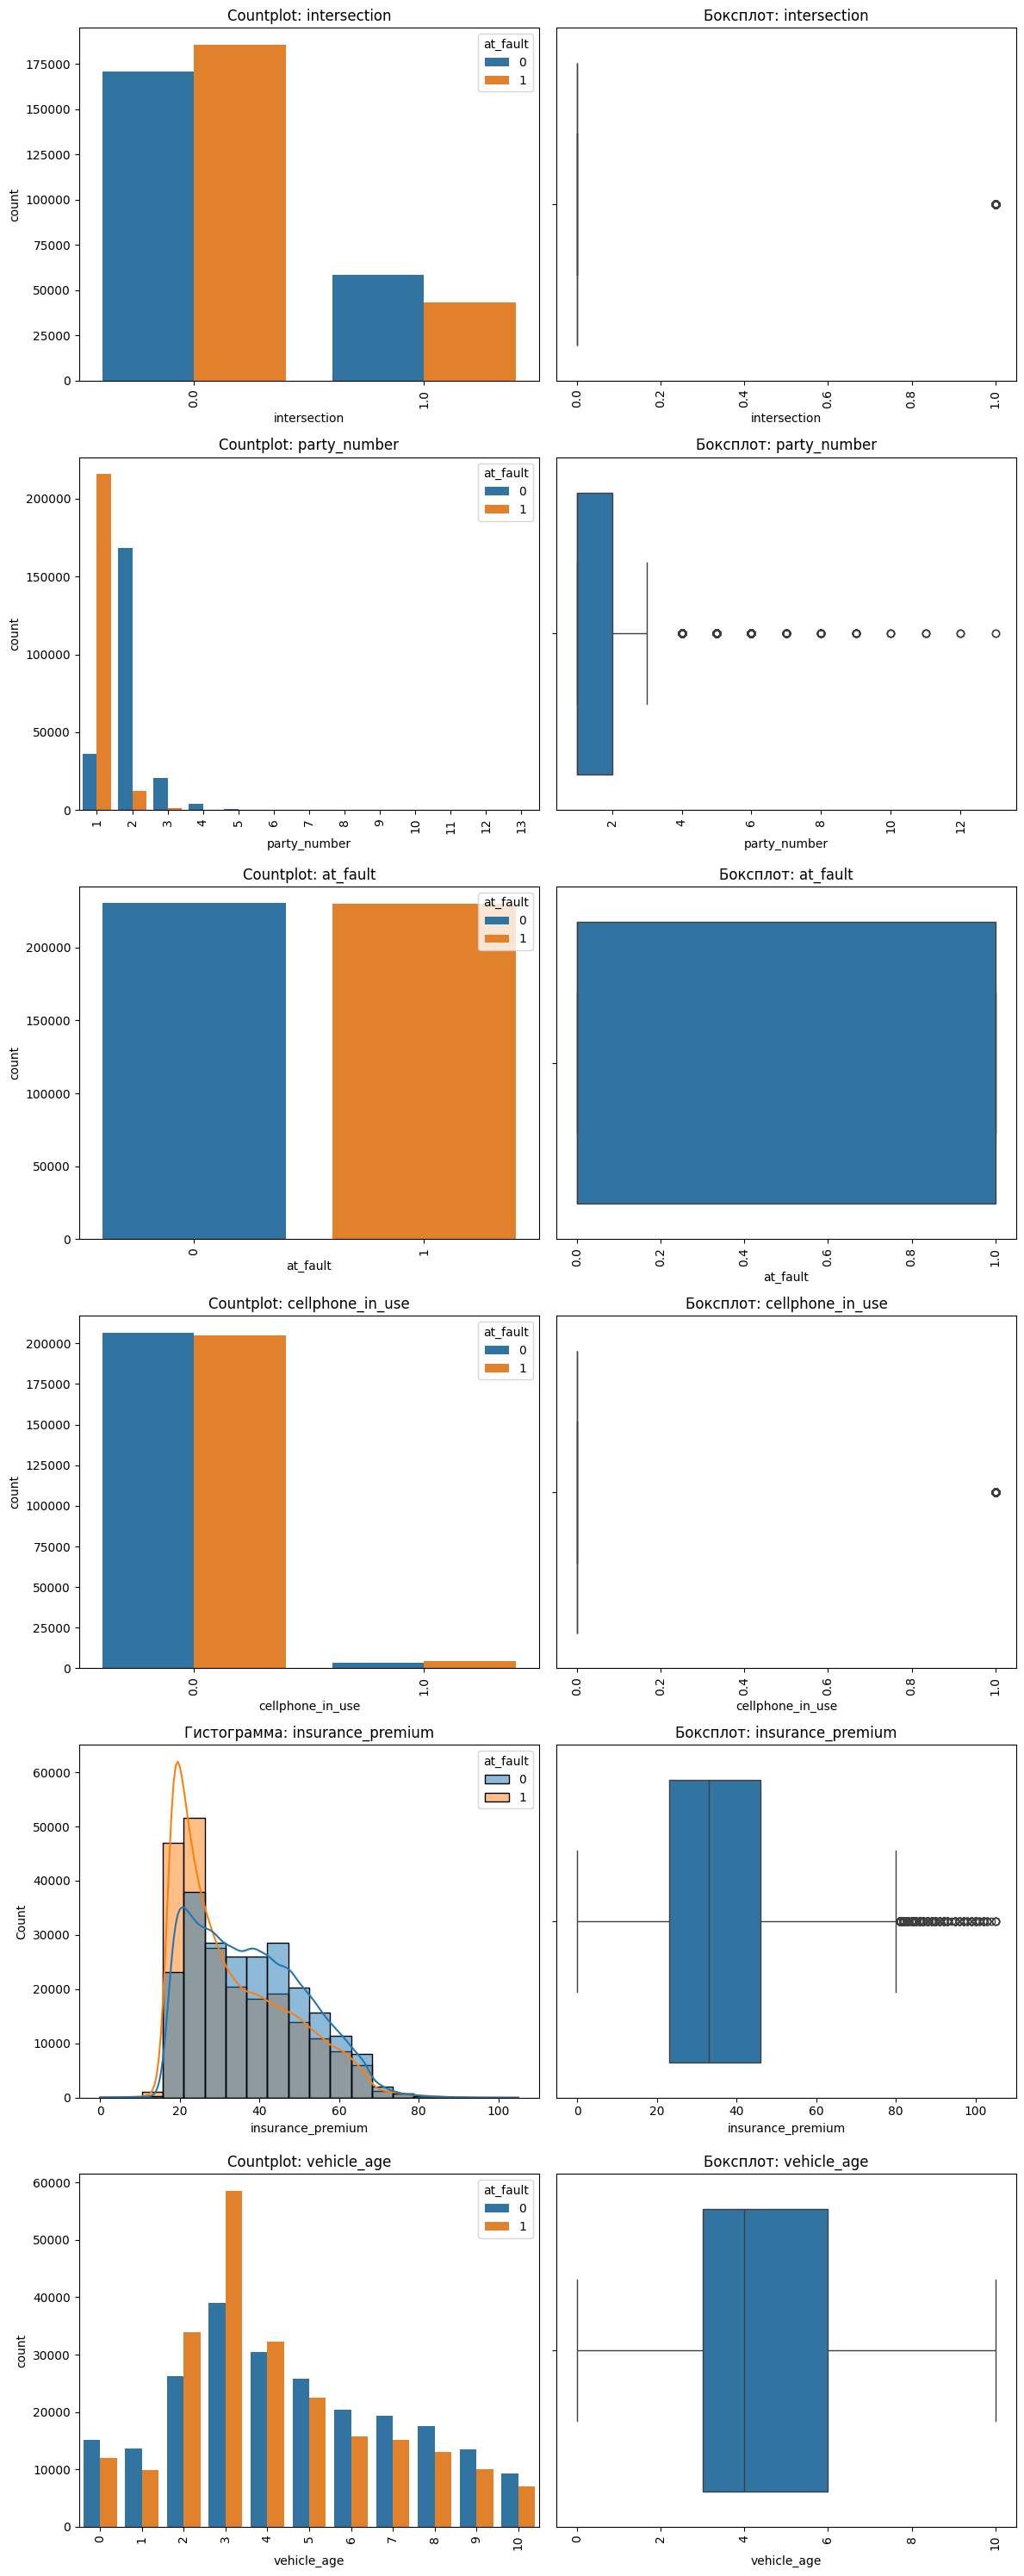

In [20]:
plot_combined(df, col=None, target='at_fault', col_type=None, legend_loc='best')

##### Выводы по численным в разрезе дтп

1) Является ли место происшествия перекрёстком	intersection - дтп в большей степени происходит вне перекрестков  
2) Число участников дтп party_number - по большому счет это следствие дтп, и тут преобладает дтп с 1-2 участниками  
3) Наличие устройства связи cellphone_in_use - по статистике никак не влияет на риск дтп  
4) Страховые взносы insurance_premium - прям влияет на риск дтп. Водители автомобилей где суммы больше - реже участвуют в дтп  
5) Возраст авто - нет явной зависимости риска дтп от возраста автомобиля. Есть непонятный всплеск у 3хлеток, но возможно это связано с повышенным уровнем использования каршеринговых авто и к этому сроку заводские агрегаты начинают изнашиваться  

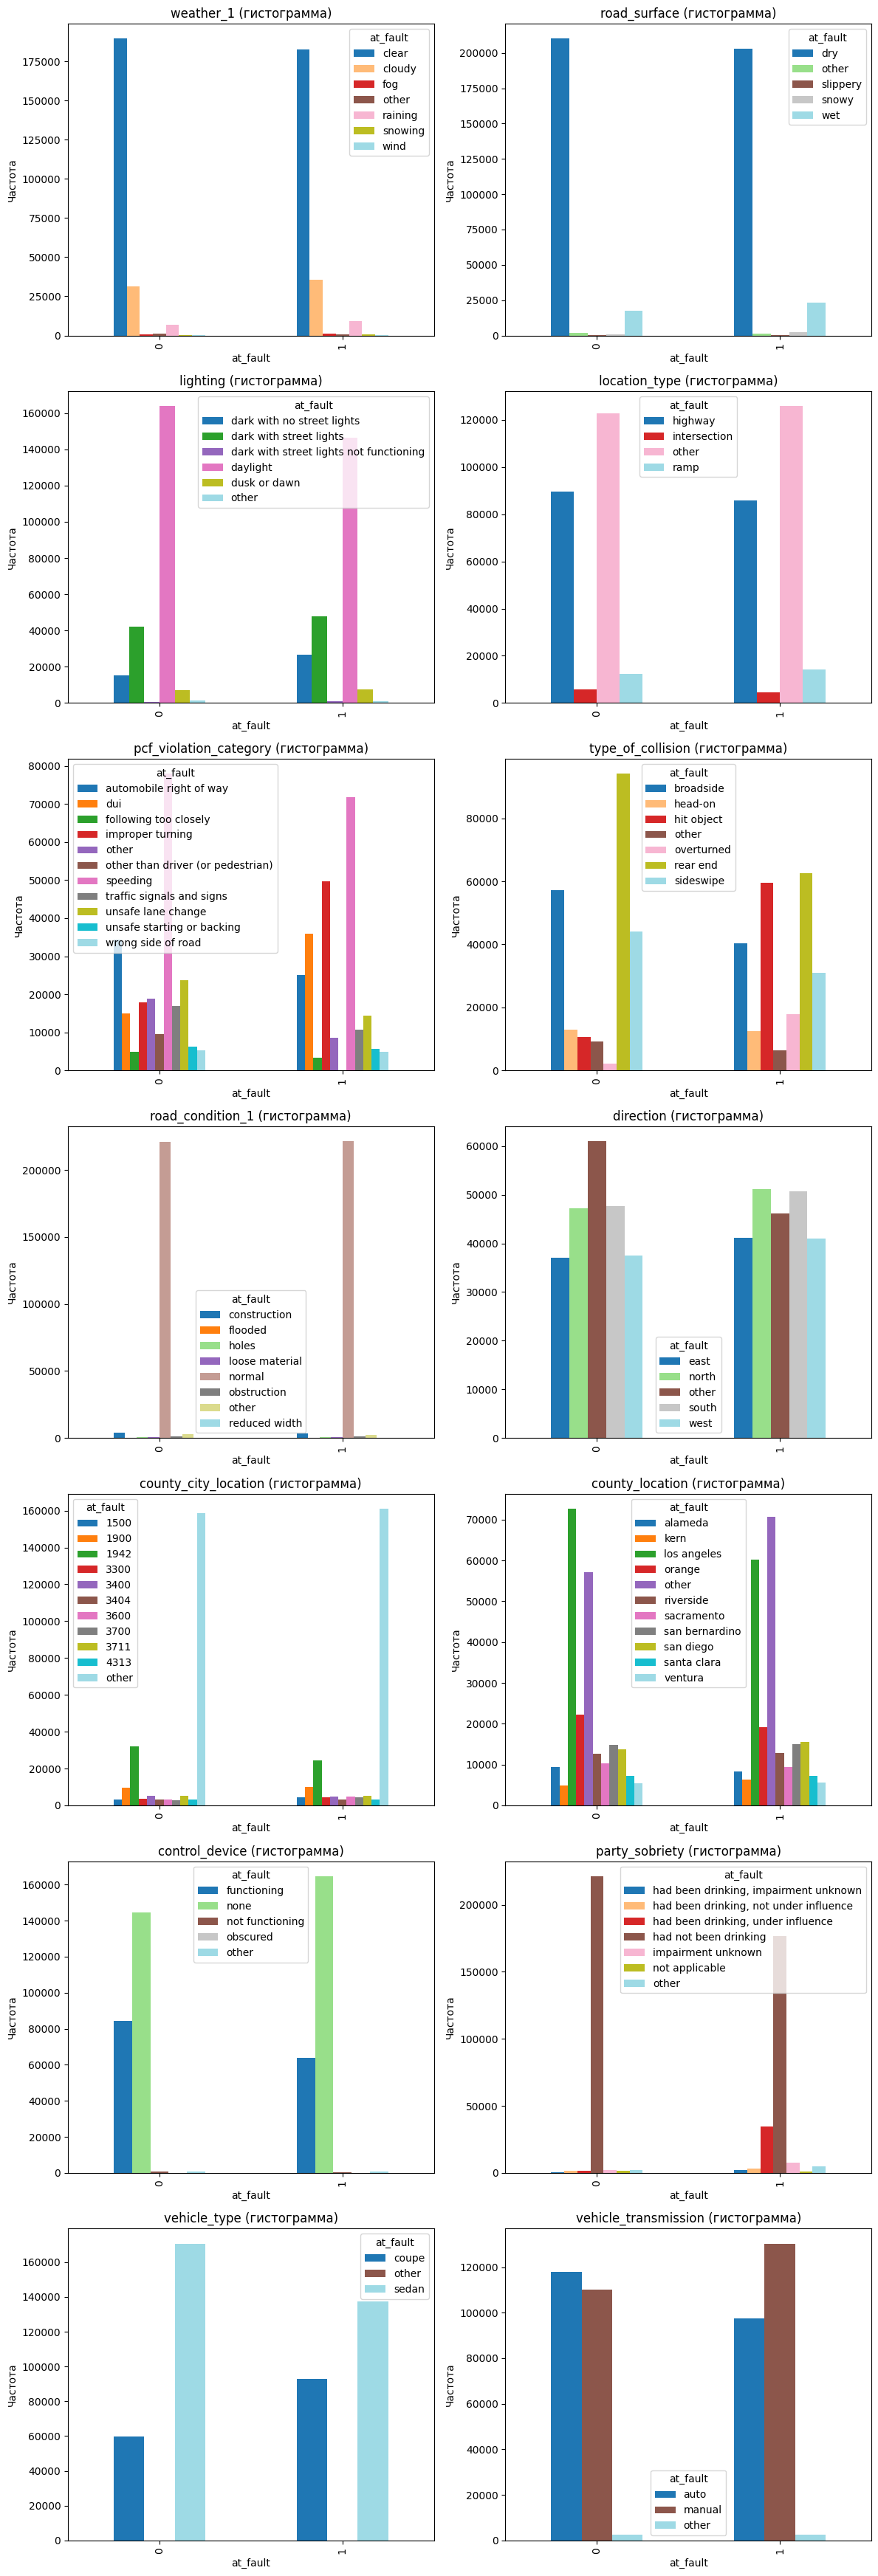

In [21]:
df_for_plot = df.drop(columns=['collision_date', 'collision_time'])
plot_categorical_columns(df_for_plot, col=None, target='at_fault', top_n=10)

Погода - большинство дтп происходит в ясную погода, сильно реже в облачную  
По освещению - лидирует темного время суток и без освещения  
Наиболее частой причиной дтп является превышение скорости  
Практически все дтп были на нормальной асфальтированной дороге без повреждений  
Больше всего дтп в лос-анжелесе  
Без приборов контроля движения - дтп происходит чаще  
Чаще всего в дтп попадают седаны, хотя у нас в выборке есть только седан, купе в меньшей степени и совсем незначительное число других авто

#### Распределение по году

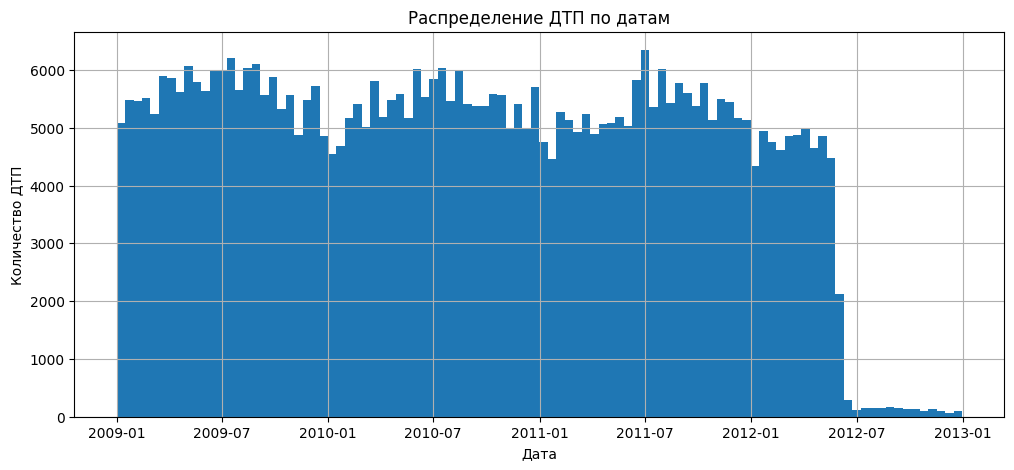

In [22]:
plt.figure(figsize=(12, 5))
df['collision_date'].hist(bins=100)
plt.title('Распределение ДТП по датам')
plt.xlabel('Дата')
plt.ylabel('Количество ДТП')
plt.show()

В целом видна цикличность возникновения дтп - летний период.

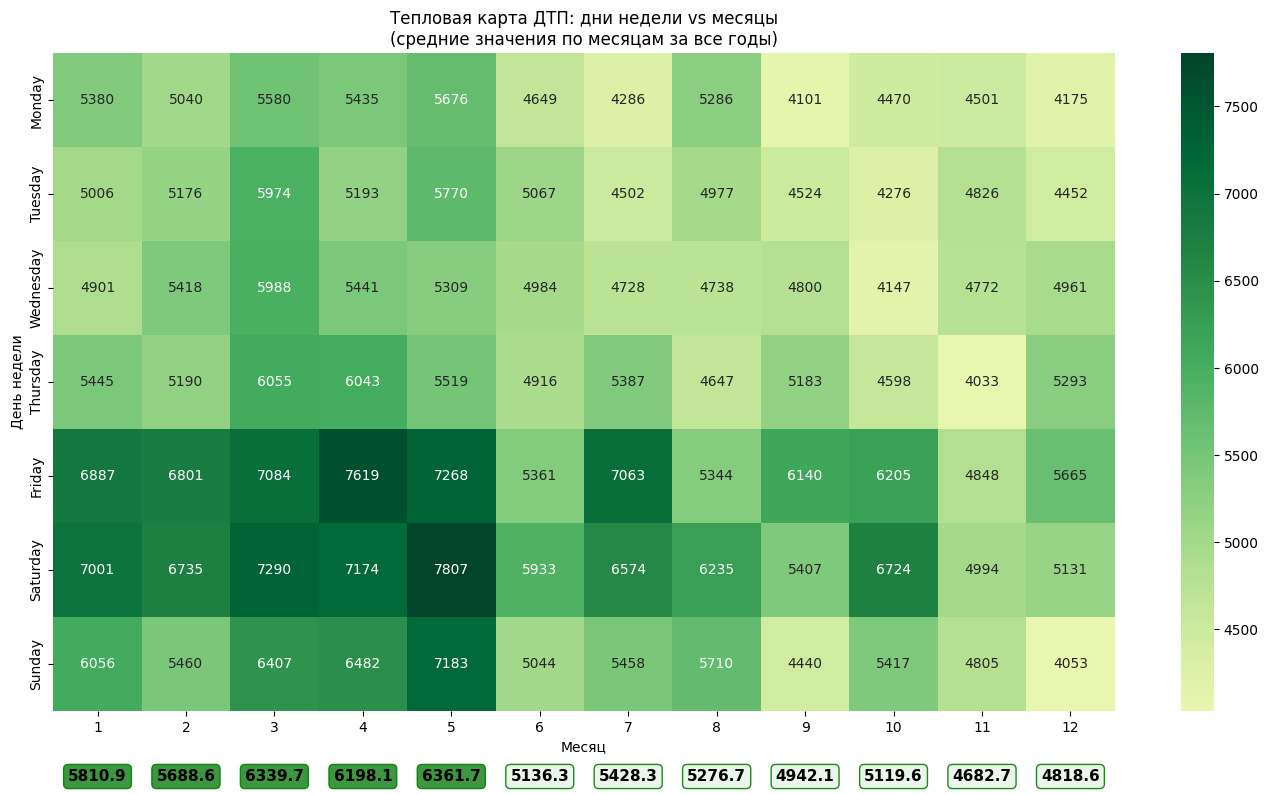

In [23]:
df['collision_date'] = pd.to_datetime(df['collision_date'])
df['collision_time'] = pd.to_datetime(df['collision_time'], format='%H:%M:%S')
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

pivot = df.groupby([df['collision_date'].dt.day_name(), df['collision_date'].dt.month]).size().unstack()
pivot = pivot.reindex(days_order)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot, annot=True, fmt='d', cmap='YlGn', center=pivot.values.mean())

monthly_means = pivot.mean(axis=0)
mean_of_means = monthly_means.mean()

for i, (month, mean_val) in enumerate(monthly_means.items()):
    if mean_val < mean_of_means:
        # Более светлый зеленый для значений ниже среднего
        color = '#e8f5e8'
        text_color = "#000000"
    else:
        # Более насыщенный зеленый для значений выше среднего
        color = "#298b2c"
        text_color = "#000000"
    
    plt.text(i + 0.5, len(pivot) + 0.7, f'{mean_val:.1f}', 
             ha='center', va='center', fontweight='bold', fontsize=11,
             color=text_color,
             bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.9, edgecolor='green', linewidth=1))

plt.title('Тепловая карта ДТП: дни недели vs месяцы\n(средние значения по месяцам за все годы)')
plt.xlabel('Месяц')
plt.ylabel('День недели')
plt.tight_layout()
plt.show()

Что касается более детального распределения:  
1) Чаще всего дтп происходят в пятницу и субботу;  
2) И в зимне весенний период - зима скользко, весна - хочется думать уже о лете и голова забиты другими мыслями

#### Распределение по времени

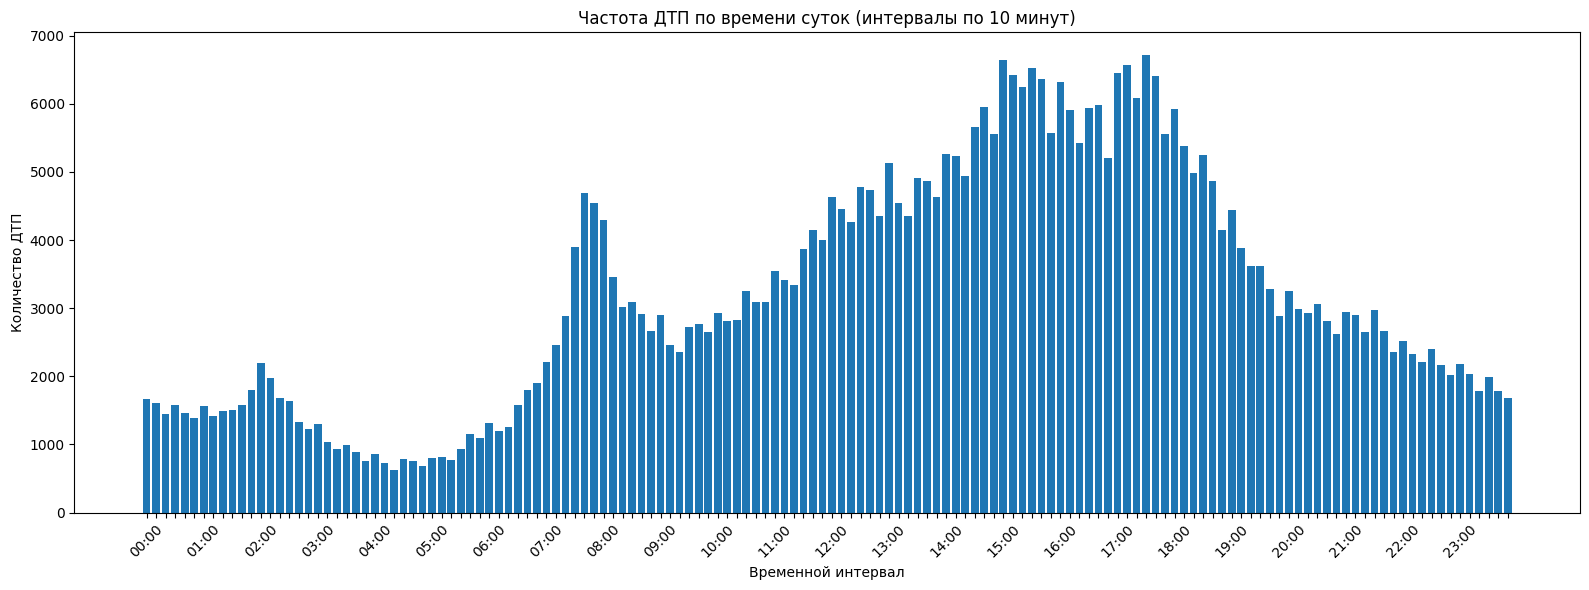

In [24]:
df_copy = df.copy()
df_copy['time_interval'] = pd.to_datetime(df_copy['collision_time'], format='%H:%M:%S').dt.floor('10min').dt.strftime('%H:%M')

plt.figure(figsize=(16, 6))
interval_counts = df_copy['time_interval'].value_counts().sort_index()

plt.bar(range(len(interval_counts)), interval_counts.values)
plt.title('Частота ДТП по времени суток (интервалы по 10 минут)')
plt.xlabel('Временной интервал')
plt.ylabel('Количество ДТП')

x_ticks = range(len(interval_counts))
x_labels = [label if i % 6 == 0 else '' for i, label in enumerate(interval_counts.index)]
plt.xticks(x_ticks, x_labels, rotation=45)

plt.tight_layout()
plt.show()

По времени ДТП также ситуация наглядная:  
1) Утренник часпик когда все едут на работу;  
2) И плавный рост после 15:00 и до вечернего часпика когда все едут домой.

In [25]:
# создаем новые признаки из даты и времени
# день месяца, день недели и час
df['day_of_month'] = df['collision_date'].dt.day
df['day_of_week'] = df['collision_date'].dt.dayofweek
df['hour'] = df['collision_time'].dt.hour

In [26]:
for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        df[col] = df[col].fillna('unknown')
    elif np.issubdtype(df[col].dtype, np.number):
        df[col] = df[col].fillna(-1)

np.int64(7)

'Удаляем'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460623 entries, 0 to 460622
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   weather_1               460623 non-null  object        
 1   road_surface            460623 non-null  object        
 2   lighting                460623 non-null  object        
 3   intersection            460623 non-null  float64       
 4   location_type           460623 non-null  object        
 5   pcf_violation_category  460623 non-null  object        
 6   type_of_collision       460623 non-null  object        
 7   road_condition_1        460623 non-null  object        
 8   direction               460623 non-null  object        
 9   collision_date          460623 non-null  datetime64[ns]
 10  collision_time          459992 non-null  datetime64[ns]
 11  county_city_location    460623 non-null  object        
 12  county_location         460623

None

,weather_1,road_surface,lighting,intersection,location_type,pcf_violation_category,type_of_collision,road_condition_1,direction,collision_date,...,at_fault,party_sobriety,cellphone_in_use,insurance_premium,vehicle_type,vehicle_age,vehicle_transmission,day_of_month,day_of_week,hour
59529,clear,dry,dark with no street lights,0.0,highway,unsafe lane change,sideswipe,normal,east,2009-11-14,...,0,had not been drinking,0.0,20.0,sedan,2,auto,14,5,21.0
387076,clear,dry,daylight,0.0,highway,unsafe lane change,hit object,normal,east,2010-08-21,...,1,had not been drinking,0.0,21.0,sedan,0,auto,21,5,17.0
132949,cloudy,dry,daylight,0.0,highway,unsafe lane change,sideswipe,normal,north,2011-05-18,...,1,had not been drinking,0.0,26.0,sedan,1,auto,18,2,15.0
354388,clear,dry,dark with street lights,1.0,unknown,automobile right of way,broadside,normal,unknown,2011-09-02,...,0,had not been drinking,0.0,19.0,sedan,3,auto,2,4,21.0
311454,cloudy,dry,dark with street lights,-1.0,unknown,dui,hit object,normal,unknown,2009-01-11,...,1,"had been drinking, under influence",0.0,19.0,sedan,2,auto,11,6,2.0


collision_time    631
dtype: int64

None

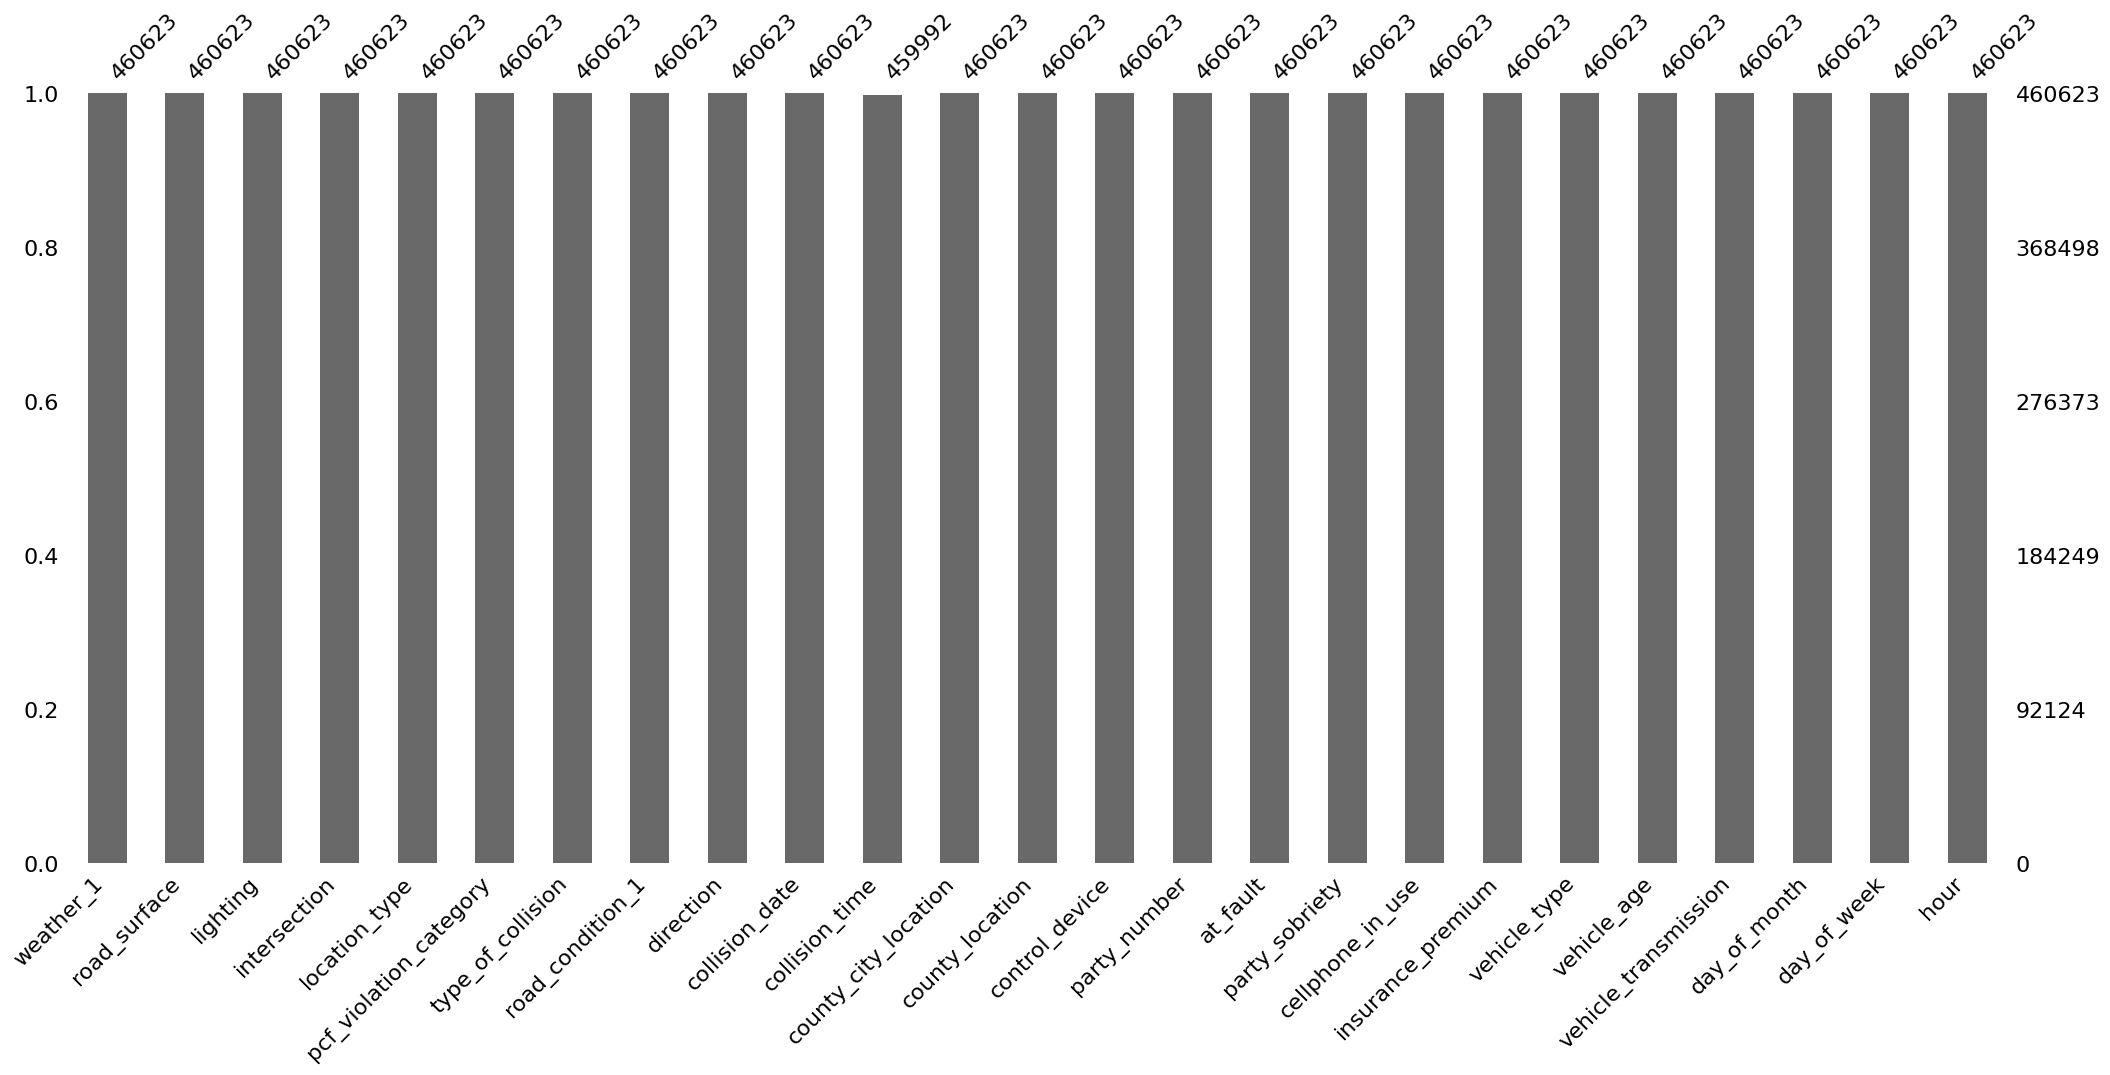

,count,mean,min,25%,50%,75%,max,std
intersection,460623.0,0.21701,-1.0,0.0,0.0,0.0,1.0,0.422617
collision_date,460623,2010-09-05 15:33:49.834376192,2009-01-01 00:00:00,2009-10-22 00:00:00,2010-08-29 00:00:00,2011-07-15 00:00:00,2012-12-30 00:00:00,NaN
collision_time,459992,1900-01-01 13:51:19.788082944,1900-01-01 00:00:00,1900-01-01 10:17:00,1900-01-01 14:45:00,1900-01-01 17:51:00,1900-01-01 23:59:00,NaN
party_number,460623.0,1.526546,1.0,1.0,1.0,2.0,13.0,0.663029
at_fault,460623.0,0.499719,0.0,0.0,0.0,1.0,1.0,0.5
cellphone_in_use,460623.0,-0.071306,-1.0,0.0,0.0,0.0,1.0,0.318167
insurance_premium,460623.0,35.09968,-1.0,23.0,32.0,46.0,105.0,14.577237
vehicle_age,460623.0,4.356843,0.0,3.0,4.0,6.0,10.0,2.592554
day_of_month,460623.0,15.656661,1.0,8.0,16.0,23.0,31.0,8.778735
day_of_week,460623.0,3.161586,0.0,1.0,3.0,5.0,6.0,1.975313


In [27]:
# проверяем результат
drop_duplicated(df)
df = check_data(df)

#### Кореляция с таргетом

2025-12-05 16:53:46 [INFO] __main__: === Дискретные признаки (исключены из корреляции) ===


'weather_1, road_surface, lighting, intersection, location_type, type_of_collision, road_condition_1, direction, control_device, party_sobriety, cellphone_in_use, vehicle_type, vehicle_transmission, day_of_week'

2025-12-05 16:53:46 [INFO] __main__: 
=== Непрерывные признаки (используются для корреляции) ===


'pcf_violation_category, county_city_location, party_number, insurance_premium, vehicle_age, day_of_month, hour'

2025-12-05 16:53:47 [INFO] __main__: 
=== Корреляция непрерывных признаков с таргетом ===


party_number             -0.687133
insurance_premium        -0.166025
pcf_violation_category   -0.126863
hour                     -0.083977
vehicle_age              -0.069907
county_city_location      0.023450
day_of_month              0.001504
Name: at_fault, dtype: float64

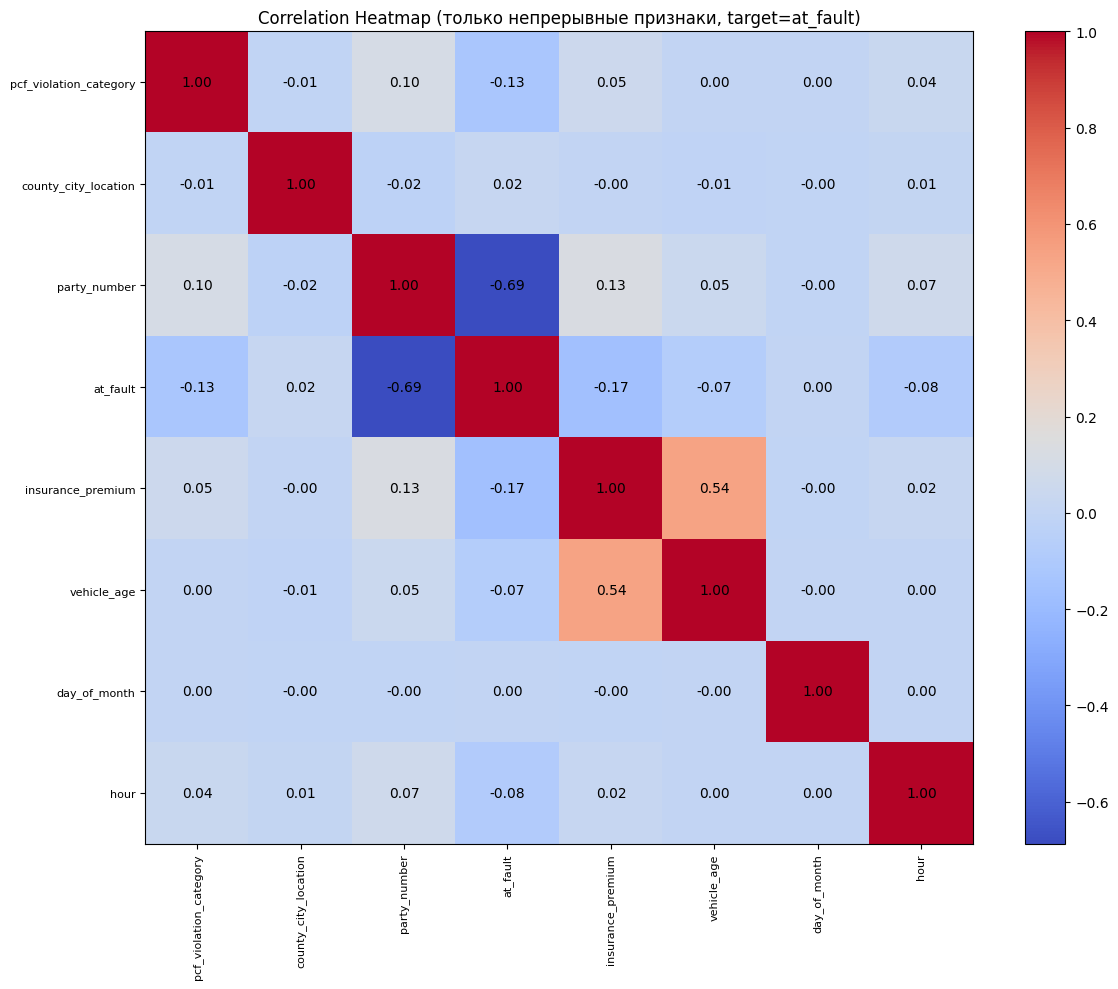

2025-12-05 16:53:47 [INFO] __main__: === VIF (только непрерывные признаки) ===


,feature,VIF
3,insurance_premium,1.484470
4,vehicle_age,1.432398
2,party_number,1.139816
0,pcf_violation_category,1.095473
6,hour,1.009045
1,county_city_location,1.003283
5,day_of_month,1.001132


In [28]:
df_cor = df.drop(columns=['collision_date', 'collision_time', 'county_location'])
calc_target_correlations(df_cor, target_col="at_fault")

По корелляции вопросов нет, как и vif - все в пределах допустимых значений

#### Подготовка обучающей и тестовой выборки

##### Константы

In [29]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
N_JOBS = 2
N_ITER = 10000 # число итераций для перебора и поиска лучших параметров
EARLY_STOP = 3
CV_SPLIT = 3

##### Оставляем только нужные признаки и данные по ним

In [30]:
# для модели нам нужен только 2012 год
df = df[df['collision_date'].between('2012-01-01', '2012-05-31')]

# уберем утечки и лишние данные
columns_to_drop = [
    'party_sobriety',
    'pcf_violation_category', 
    'type_of_collision',
    'collision_date',
    'collision_time',
    'party_number',
    'county_location'
]

df = df.drop(columns=columns_to_drop)

##### Разделим данные на выборки для обучения

In [31]:
# разделим на выборки
df_train, df_test = train_test_split(
    df, 
    test_size=0.2,
    stratify=df['at_fault'], 
    random_state=RANDOM_STATE
)

# Устанавливаем X и y
X_train = df_train.drop(['at_fault'], axis=1)
y_train = df_train['at_fault']

X_test = df_test.drop(['at_fault'], axis=1)
y_test = df_test['at_fault']

logger.info(f"Размеры выборок: Train={X_train.shape}, Test={X_test.shape}")
logger.info(f"Распределение таргета - Train: {y_train.value_counts(normalize=True).to_dict()}")
logger.info(f"Распределение таргета - Test: {y_test.value_counts(normalize=True).to_dict()}")

2025-12-05 16:53:48 [INFO] __main__: Размеры выборок: Train=(38918, 17), Test=(9730, 17)
2025-12-05 16:53:48 [INFO] __main__: Распределение таргета - Train: {1: 0.5023125546019837, 0: 0.49768744539801635}
2025-12-05 16:53:48 [INFO] __main__: Распределение таргета - Test: {1: 0.5023638232271326, 0: 0.4976361767728674}


# Шаг 5. Найдите лучшую модель

1) Смоделируйте не менее 3-х типов моделей с перебором гиперпараметров.  
2) Выберите метрику для оценки модели, исходя из поставленной бизнесом задачи. Обоснуйте свой выбор.  
3) Оформите вывод в виде сравнительной таблицы.  

## Подготовимся к обучению

In [32]:
# сюда будем писать результаты
results = {}

# разделяем признаки
cat_selector = make_column_selector(dtype_include=["object", "category", "bool"])
num_selector = make_column_selector(dtype_include=[np.number])

# циклические признаки
cic = ['day_of_month', 'day_of_week', 'hour']
cyclic_cols = [c for c in cic if c in X_train.columns]

cat_cols = cat_selector(X_train)
num_cols = [c for c in num_selector(X_train) if c not in cyclic_cols]

if not cyclic_cols:
    logger.warning(f"Циклические признаки {cic} не найдены в данных")

display("Категориальные:", cat_cols)
display("Числовые:", num_cols)
display("Циклические:", cyclic_cols)
logger.info(f"Всего: {len(cat_cols)} категориальных, {len(num_cols)} числовых, {len(cyclic_cols)} циклических")

'Категориальные:'

['weather_1',
 'road_surface',
 'lighting',
 'location_type',
 'road_condition_1',
 'direction',
 'county_city_location',
 'control_device',
 'vehicle_type',
 'vehicle_transmission']

'Числовые:'

['intersection', 'cellphone_in_use', 'insurance_premium', 'vehicle_age']

'Циклические:'

['day_of_month', 'day_of_week', 'hour']

2025-12-05 16:53:48 [INFO] __main__: Всего: 10 категориальных, 4 числовых, 3 циклических


In [33]:
to_str = FunctionTransformer(lambda x: x.astype(str))

def create_cyclic_features(X):
    out = pd.DataFrame(index=X.index)

    if 'hour' in X.columns:
        out['hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
        out['hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)
    
    if 'day_of_week' in X.columns:
        out['day_of_week_sin'] = np.sin(2 * np.pi * X['day_of_week'] / 7)
        out['day_of_week_cos'] = np.cos(2 * np.pi * X['day_of_week'] / 7)
    
    if 'day_of_month' in X.columns:
        # Предполагаем максимальную длину месяца 31 день
        out['day_of_month_sin'] = np.sin(2 * np.pi * X['day_of_month'] / 31)
        out['day_of_month_cos'] = np.cos(2 * np.pi * X['day_of_month'] / 31)

    return out

def cyclic_feature_names_out(transformer, input_features):
    features = []
    if 'hour' in input_features:
        features.extend(['hour_sin', 'hour_cos'])
    if 'day_of_week' in input_features:
        features.extend(['day_of_week_sin', 'day_of_week_cos'])
    if 'day_of_month' in input_features:
        features.extend(['day_of_month_sin', 'day_of_month_cos'])
    return np.array(features)

cyclic_transformer = FunctionTransformer(
    func=create_cyclic_features,
    feature_names_out=cyclic_feature_names_out,
    validate=False
)

def suggest_param(trial, name, spec):
    if isinstance(spec, tuple):
        if len(spec) == 3 and spec[2] == "log":
            return trial.suggest_float(name, spec[0], spec[1], log=True)
        elif len(spec) == 3:  # int с шагом
            return trial.suggest_int(name, spec[0], spec[1], step=spec[2])
        else:  # обычный int
            return trial.suggest_int(name, spec[0], spec[1])
    elif isinstance(spec, list):
        return trial.suggest_categorical(name, spec)
    else:
        raise ValueError(f"Unsupported param spec: {spec}")

In [34]:
preprocessor_linear = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cyclic", Pipeline([
            ("cyclic", cyclic_transformer),
            ("scaler", StandardScaler())
        ]), cyclic_cols),
        ("cat", Pipeline([
            ("to_str", to_str),
            ("imputer", SimpleImputer(strategy='constant', fill_value='missing')),
            ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False))
        ]), cat_cols)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# Для деревьев и бустингов
preprocessor_tree = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cyclic", cyclic_transformer, cyclic_cols),
        ("cat", Pipeline([
            ("to_str", to_str),
            ("imputer", SimpleImputer(strategy='constant', fill_value='missing')),
            ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=999999))
        ]), cat_cols)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

In [35]:
models = {
    "LogisticRegression": (lambda: LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight="balanced"), preprocessor_linear),
    "DecisionTree": (lambda: DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced"), preprocessor_tree),
    "RandomForest": (lambda: RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS, class_weight="balanced"), preprocessor_tree),
    "LightGBM": (lambda: LGBMClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS, verbosity=-1), preprocessor_tree)
}

In [36]:
param_grid = {
    "LogisticRegression": {
        "C": (0.001, 10, "log")
    },
    "RandomForest": {
        "n_estimators": (100, 1000, 100),
        "max_depth": (3, 15),
        "min_samples_split": (2, 15),
        "min_samples_leaf": (1, 5),
        "max_features": ["sqrt", "log2"]
    },
    "DecisionTree": {
        "max_depth": (3, 15),
        "min_samples_split": (2, 15),
        "min_samples_leaf": (1, 5),
        "max_features": ["sqrt", "log2"]
    },
    "LightGBM": {
        "n_estimators": (100, 1000, 100),
        "max_depth": (3, 15),
        "learning_rate": (0.01, 0.3, "log"),
        "num_leaves": (20, 128),
        "min_child_samples": (10, 60)
    }
}

In [37]:
def objective_model(trial, model_name, preprocessor):
    k_max = min(100, X_train.shape[1])
    k_best = trial.suggest_int("selectkbest__k", 10, k_max)

    pgrid = param_grid[model_name]

    if model_name == "LogisticRegression":
        C = suggest_param(trial, "C", pgrid["C"])
        model = LogisticRegression(
            C=C,
            random_state=RANDOM_STATE,
            max_iter=1000,
            class_weight="balanced"
        )
    elif model_name in ["RandomForest", "DecisionTree"]:
        cls = RandomForestClassifier if model_name == "RandomForest" else DecisionTreeClassifier
        model_params = {}
        for key, spec in pgrid.items():
            model_params[key] = suggest_param(trial, key, spec)
        model_params["random_state"] = RANDOM_STATE
        if model_name == "RandomForest":
            model_params["n_jobs"] = N_JOBS
        model_params["class_weight"] = "balanced"
        model = cls(**model_params)
    elif model_name == "LightGBM":
        model_params = {}
        for key, spec in pgrid.items():
            model_params[key] = suggest_param(trial, key, spec)
        model_params["random_state"] = RANDOM_STATE
        model_params["n_jobs"] = N_JOBS
        model_params["verbosity"] = -1
        model_params["class_weight"] = "balanced"
        model = LGBMClassifier(**model_params)

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("selectkbest", SelectKBest(score_func=f_classif, k=k_best)),
        ("classifier", model)
    ])
    
    cv = StratifiedKFold(n_splits=CV_SPLIT, shuffle=True, random_state=RANDOM_STATE)
    
    cv_results = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring={
            'f1': 'f1',
            'roc_auc': 'roc_auc',
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall'
        },
        n_jobs=N_JOBS,
        return_train_score=False
    )
    
    f1_mean = cv_results['test_f1'].mean()
    
    trial.set_user_attr('cv_metrics', {
        'f1_mean': cv_results['test_f1'].mean(),
        'f1_std': cv_results['test_f1'].std(),
        'roc_auc_mean': cv_results['test_roc_auc'].mean(),
        'roc_auc_std': cv_results['test_roc_auc'].std(),
        'accuracy_mean': cv_results['test_accuracy'].mean(),
        'accuracy_std': cv_results['test_accuracy'].std(),
        'precision_mean': cv_results['test_precision'].mean(),
        'precision_std': cv_results['test_precision'].std(),
        'recall_mean': cv_results['test_recall'].mean(),
        'recall_std': cv_results['test_recall'].std()
    })
    
    trial.report(f1_mean, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    return f1_mean

Для оптимизации моделей будем использовать F1 метрику, потому, что нам важно предупредить водителя, что на данном участке может быть ДТП.  
Если бы нам важно было бы именно избежать ДТП в любом случае, то правильнее было бы уже использовать F2 метрику с повышенной beta, т.е. ложные сработки не критичны, главное точно предсказать, что будет ДТП.

## Подбор лучшей модели

In [38]:
class EarlyStoppingCallback:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = -np.inf
        self.no_improvement_count = 0

    def __call__(self, study, trial):
        if study.best_value > self.best_score + self.min_delta:
            self.best_score = study.best_value
            self.no_improvement_count = 0
        else:
            self.no_improvement_count += 1

        if self.no_improvement_count >= self.patience:
            study.stop()
            logger.info(f"Ранняя остановка: нет улучшений {self.patience} trials")

In [39]:
best_models = {}
study_results = []

early_stop_cb = EarlyStoppingCallback(patience=EARLY_STOP)

def log_every_N_trials(study, trial, N=100):
    if trial.number % N == 0:
        best_trial = study.best_trial
        logger.info(
            f"[Trial {trial.number} finished]. Trial {best_trial.number} is best: F1={best_trial.value:.4f}"
        )

for model_name, (model_factory, preprocessor) in models.items():
    logger.info(f"\n\n=== Optimizing {model_name} ===")

    pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=0)
    study = optuna.create_study(direction="maximize", pruner=pruner, sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))

    study.optimize(
        lambda trial: objective_model(trial, model_name, preprocessor),
        n_trials=N_ITER,
        callbacks=[log_every_N_trials, early_stop_cb]
    )

    best_params = study.best_params
    best_trial = study.best_trial
    cv_metrics = best_trial.user_attrs.get('cv_metrics', {})
    
    logger.info(f"Best trial {best_trial.number} -> F1={best_trial.value:.4f}, params={best_params}")
    logger.info(f"CV метрики: F1={cv_metrics.get('f1_mean', 0):.4f}±{cv_metrics.get('f1_std', 0):.4f}, "
                f"ROC-AUC={cv_metrics.get('roc_auc_mean', 0):.4f}±{cv_metrics.get('roc_auc_std', 0):.4f}")

    k_best_final = best_params.get("selectkbest__k", X_train.shape[1])

    if model_name == "LogisticRegression":
        C = best_params.get("C", 1.0)
        best_model = LogisticRegression(
            C=C,
            random_state=RANDOM_STATE,
            max_iter=1000,
            class_weight="balanced"
        )

    elif model_name in ["RandomForest", "DecisionTree"]:
        cls = RandomForestClassifier if model_name == "RandomForest" else DecisionTreeClassifier
        model_params = {}
        for key, spec in param_grid[model_name].items():
            if key in best_params:
                model_params[key] = best_params[key]
            else:
                model_params[key] = spec[0] if isinstance(spec, tuple) else spec[0] if isinstance(spec, list) else spec
        model_params["random_state"] = RANDOM_STATE
        if model_name == "RandomForest":
            model_params["n_jobs"] = N_JOBS
        model_params["class_weight"] = "balanced"
        best_model = cls(**model_params)

    elif model_name == "LightGBM":
        model_params = {}
        for key, spec in param_grid[model_name].items():
            if key in best_params:
                model_params[key] = best_params[key]
            else:
                model_params[key] = spec[0] if isinstance(spec, tuple) else spec[0] if isinstance(spec, list) else spec
        model_params["random_state"] = RANDOM_STATE
        model_params["n_jobs"] = N_JOBS
        model_params["verbosity"] = -1
        model_params["class_weight"] = "balanced"
        best_model = LGBMClassifier(**model_params)

    final_pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("selectkbest", SelectKBest(score_func=f_classif, k=k_best_final)),
        ("classifier", best_model)
    ])

    final_pipe.fit(X_train, y_train)
    best_models[model_name] = final_pipe

    study_results.append({
        "Model": model_name,
        "Best_params": best_params,
        "F1_CV_mean": cv_metrics.get('f1_mean', best_trial.value),
        "F1_CV_std": cv_metrics.get('f1_std', 0),
        "ROC_AUC_CV_mean": cv_metrics.get('roc_auc_mean', 0),
        "ROC_AUC_CV_std": cv_metrics.get('roc_auc_std', 0),
        "Accuracy_CV_mean": cv_metrics.get('accuracy_mean', 0),
        "Accuracy_CV_std": cv_metrics.get('accuracy_std', 0),
        "Precision_CV_mean": cv_metrics.get('precision_mean', 0),
        "Precision_CV_std": cv_metrics.get('precision_std', 0),
        "Recall_CV_mean": cv_metrics.get('recall_mean', 0),
        "Recall_CV_std": cv_metrics.get('recall_std', 0)
    })

2025-12-05 16:53:48 [INFO] __main__: 

=== Optimizing LogisticRegression ===
2025-12-05 16:53:51 [INFO] __main__: [Trial 0 finished]. Trial 0 is best: F1=0.6224
2025-12-05 16:53:53 [INFO] __main__: Ранняя остановка: нет улучшений 3 trials
2025-12-05 16:53:53 [INFO] __main__: Best trial 0 -> F1=0.6224, params={'selectkbest__k': 12, 'C': 6.351221010640703}
2025-12-05 16:53:53 [INFO] __main__: CV метрики: F1=0.6224±0.0034, ROC-AUC=0.6674±0.0021
2025-12-05 16:53:54 [INFO] __main__: 

=== Optimizing DecisionTree ===
2025-12-05 16:53:54 [INFO] __main__: [Trial 0 finished]. Trial 0 is best: F1=0.5784
2025-12-05 16:53:54 [INFO] __main__: Ранняя остановка: нет улучшений 3 trials
2025-12-05 16:53:54 [INFO] __main__: Best trial 0 -> F1=0.5784, params={'selectkbest__k': 12, 'max_depth': 15, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'sqrt'}
2025-12-05 16:53:54 [INFO] __main__: CV метрики: F1=0.5784±0.0079, ROC-AUC=0.6352±0.0026
2025-12-05 16:53:55 [INFO] __main__: 

=== Optimi

## Сравнение результатов

2025-12-05 16:54:23 [INFO] __main__: Сравнение моделей на кросс-валидации
2025-12-05 16:54:23 [INFO] __main__: Лучшая модель по кросс-валидации: LogisticRegression


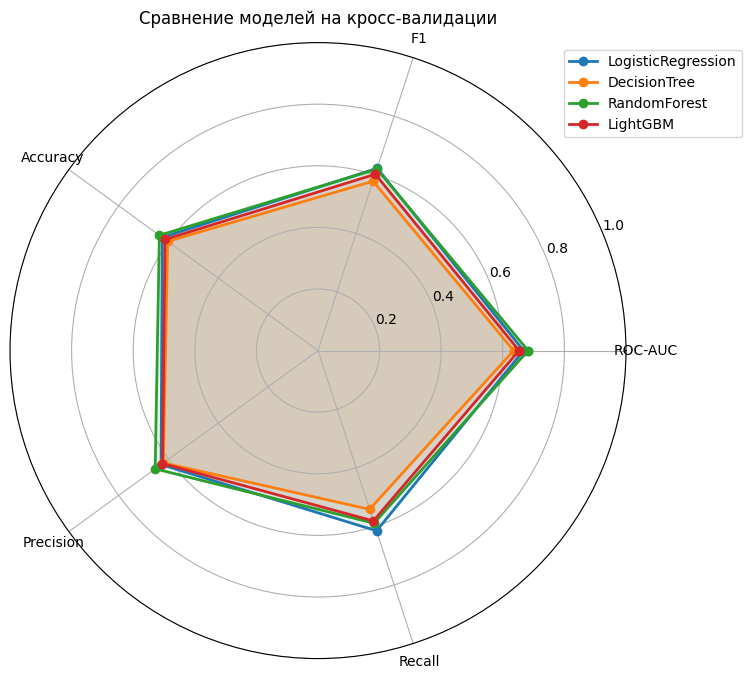

2025-12-05 16:54:24 [INFO] __main__: Лучшая модель для дальнейшего анализа: LogisticRegression


In [40]:
logger.info("Сравнение моделей на кросс-валидации")

# Выбираем лучшую модель по кросс-валидации
best_cv_model = max(study_results, key=lambda x: x["F1_CV_mean"])
best_model_name_cv = best_cv_model["Model"]
best_model_cv = best_models[best_model_name_cv]

logger.info(f"Лучшая модель по кросс-валидации: {best_model_name_cv}")

# Radar chart для сравнения моделей на кросс-валидации
metrics_radar_cv = ['ROC_AUC_CV_mean', 'F1_CV_mean', 'Accuracy_CV_mean', 'Precision_CV_mean', 'Recall_CV_mean']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, polar=True)

for res in study_results:
    values = [res[metric] for metric in metrics_radar_cv]
    values = values + values[:1]
    
    angles = [n / float(len(metrics_radar_cv)) * 2 * np.pi for n in range(len(metrics_radar_cv))]
    angles = angles + angles[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=res['Model'])
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(['ROC-AUC', 'F1', 'Accuracy', 'Precision', 'Recall'])
ax.set_ylim(0, 1)
plt.title('Сравнение моделей на кросс-валидации')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

logger.info(f"Лучшая модель для дальнейшего анализа: {best_model_name_cv}")
best_model = best_model_cv

## Оценка лучшей модели

In [41]:
logger.info("Оценка лучшей модели на тестовой выборке")

y_test_pred = best_model.predict_proba(X_test)[:, 1]
y_test_bin = (y_test_pred >= 0.5).astype(int)

roc_auc_test = roc_auc_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_bin)
accuracy_test = accuracy_score(y_test, y_test_bin)
precision_test = precision_score(y_test, y_test_bin)
recall_test = recall_score(y_test, y_test_bin)

cm = confusion_matrix(y_test, y_test_bin)
cm_df = pd.DataFrame(
    cm,
    index=["0", "1"],
    columns=["0", "1"]
)

logger.info(f"Лучшая модель: {best_model_name_cv}")
logger.info("Матрица ошибок:")
display(cm_df.style.set_caption("Матрица ошибок"))

logger.info("Метрики качества:")
metrics_test = pd.DataFrame({
    "Метрика": ["ROC-AUC", "F1-Score", "Accuracy", "Precision", "Recall"],
    "Значение": [roc_auc_test, f1_test, accuracy_test, precision_test, recall_test]
})
display(metrics_test.style.set_caption("Метрики модели на тестовой выборке"))

logger.info(f"Точность (Precision) = {precision_test:.2%}:")
logger.info(f"Из всех водителей, которых модель назвала виновными, {precision_test:.2%} действительно виновны.")
logger.info(f"Это важно для страховых выплат - минимизация ложных обвинений.")

logger.info(f"Полнота (Recall) = {recall_test:.2%}:")
logger.info(f"Модель находит {recall_test:.2%} всех виновных водителей.")
logger.info("Это важно для безопасности - выявление максимального числа виновных.")

logger.info(f"F1-мера = {f1_test:.2%}:")
logger.info("Баланс между точностью и полнотой. Хороший показатель общего качества.")

logger.info(f"Матрица ошибок показывает:")
logger.info(f"- Правильно определены невиновные: {cm[0,0]:,} случаев")
logger.info(f"- Правильно определены виновные: {cm[1,1]:,} случаев")
logger.info(f"- Ложно обвинены: {cm[0,1]:,} случаев (ошибка 1-го рода)")
logger.info(f"- Пропущены виновные: {cm[1,0]:,} случаев (ошибка 2-го рода)")

2025-12-05 16:54:24 [INFO] __main__: Оценка лучшей модели на тестовой выборке
2025-12-05 16:54:24 [INFO] __main__: Лучшая модель: LogisticRegression
2025-12-05 16:54:24 [INFO] __main__: Матрица ошибок:


,0,1
0,3069,1773
1,1920,2968


2025-12-05 16:54:24 [INFO] __main__: Метрики качества:


,Метрика,Значение
0,ROC-AUC,0.660812
1,F1-Score,0.616471
2,Accuracy,0.620452
3,Precision,0.626028
4,Recall,0.607201


2025-12-05 16:54:24 [INFO] __main__: Точность (Precision) = 62.60%:
2025-12-05 16:54:24 [INFO] __main__: Из всех водителей, которых модель назвала виновными, 62.60% действительно виновны.
2025-12-05 16:54:24 [INFO] __main__: Это важно для страховых выплат - минимизация ложных обвинений.
2025-12-05 16:54:24 [INFO] __main__: Полнота (Recall) = 60.72%:
2025-12-05 16:54:24 [INFO] __main__: Модель находит 60.72% всех виновных водителей.
2025-12-05 16:54:24 [INFO] __main__: Это важно для безопасности - выявление максимального числа виновных.
2025-12-05 16:54:24 [INFO] __main__: F1-мера = 61.65%:
2025-12-05 16:54:24 [INFO] __main__: Баланс между точностью и полнотой. Хороший показатель общего качества.
2025-12-05 16:54:24 [INFO] __main__: Матрица ошибок показывает:
2025-12-05 16:54:24 [INFO] __main__: - Правильно определены невиновные: 3,069 случаев
2025-12-05 16:54:24 [INFO] __main__: - Правильно определены виновные: 2,968 случаев
2025-12-05 16:54:24 [INFO] __main__: - Ложно обвинены: 1,773 

## Проверка модели на адекватность

In [42]:
logger.info("Проверка на адекватность модели")

dummy_strategies = ['stratified', 'most_frequent', 'prior', 'uniform']
dummy_results = []

for strategy in dummy_strategies:
    dummy = DummyClassifier(strategy=strategy, random_state=RANDOM_STATE)
    dummy.fit(X_train, y_train)
    
    y_dummy_pred = dummy.predict_proba(X_test)[:, 1] if hasattr(dummy, 'predict_proba') else dummy.predict(X_test)
    
    if strategy in ['most_frequent', 'prior']:
        y_dummy_bin = dummy.predict(X_test)
        y_dummy_pred = y_dummy_bin
    else:
        y_dummy_bin = (y_dummy_pred >= 0.5).astype(int)
    
    dummy_results.append({
        'Strategy': strategy,
        'Description': {
            'stratified': 'Случайно по распределению классов в train',
            'most_frequent': 'Всегда предсказывает самый частый класс',
            'prior': 'Предсказывает по априорной вероятности классов',
            'uniform': 'Случайно равномерно'
        }[strategy],
        'ROC_AUC': roc_auc_score(y_test, y_dummy_pred) if strategy not in ['most_frequent', 'prior'] else 0.5,
        'F1': f1_score(y_test, y_dummy_bin),
        'Accuracy': accuracy_score(y_test, y_dummy_bin),
        'Precision': precision_score(y_test, y_dummy_bin, zero_division=0),
        'Recall': recall_score(y_test, y_dummy_bin, zero_division=0)
    })

dummy_df = pd.DataFrame(dummy_results)

best_dummy_idx = dummy_df['F1'].idxmax()
best_dummy = dummy_df.loc[best_dummy_idx]

logger.info("Результаты константных моделей:")
display(dummy_df.style.set_caption("Метрики DummyClassifier на тестовой выборке"))

logger.info(f"Лучшая константная стратегия: '{best_dummy['Strategy']}'")
logger.info(f"Описание: {best_dummy['Description']}")
logger.info("Сравнение: Лучшая модель vs Константная модель")

# Сравнительная таблица
comparison_df = pd.DataFrame({
    'Метрика': ['ROC-AUC', 'F1-Score', 'Accuracy', 'Precision', 'Recall'],
    'Наша модель': [roc_auc_test, f1_test, accuracy_test, precision_test, recall_test],
    'Константная модель': [best_dummy['ROC_AUC'], best_dummy['F1'], 
                          best_dummy['Accuracy'], best_dummy['Precision'], 
                          best_dummy['Recall']],
    'Разница': [roc_auc_test - best_dummy['ROC_AUC'], 
                f1_test - best_dummy['F1'],
                accuracy_test - best_dummy['Accuracy'],
                precision_test - best_dummy['Precision'],
                recall_test - best_dummy['Recall']],
    'Улучшение %': [
        ((roc_auc_test / best_dummy['ROC_AUC']) - 1) * 100 if best_dummy['ROC_AUC'] > 0 else float('inf'),
        ((f1_test / best_dummy['F1']) - 1) * 100 if best_dummy['F1'] > 0 else float('inf'),
        ((accuracy_test / best_dummy['Accuracy']) - 1) * 100 if best_dummy['Accuracy'] > 0 else float('inf'),
        ((precision_test / best_dummy['Precision']) - 1) * 100 if best_dummy['Precision'] > 0 else float('inf'),
        ((recall_test / best_dummy['Recall']) - 1) * 100 if best_dummy['Recall'] > 0 else float('inf')
    ]
})

display(comparison_df.style.set_caption("Сравнение с константной моделью"))

2025-12-05 16:54:24 [INFO] __main__: Проверка на адекватность модели
2025-12-05 16:54:24 [INFO] __main__: Результаты константных моделей:


,Strategy,Description,ROC_AUC,F1,Accuracy,Precision,Recall
0,stratified,Случайно по распределению классов в train,0.497893,0.504514,0.497945,0.500302,0.508797
1,most_frequent,Всегда предсказывает самый частый класс,0.500000,0.668765,0.502364,0.502364,1.000000
2,prior,Предсказывает по априорной вероятности классов,0.500000,0.668765,0.502364,0.502364,1.000000
3,uniform,Случайно равномерно,0.500000,0.668765,0.502364,0.502364,1.000000


2025-12-05 16:54:24 [INFO] __main__: Лучшая константная стратегия: 'most_frequent'
2025-12-05 16:54:24 [INFO] __main__: Описание: Всегда предсказывает самый частый класс
2025-12-05 16:54:24 [INFO] __main__: Сравнение: Лучшая модель vs Константная модель


,Метрика,Наша модель,Константная модель,Разница,Улучшение %
0,ROC-AUC,0.660812,0.500000,0.160812,32.162476
1,F1-Score,0.616471,0.668765,-0.052293,-7.819413
2,Accuracy,0.620452,0.502364,0.118088,23.506547
3,Precision,0.626028,0.502364,0.123664,24.616510
4,Recall,0.607201,1.000000,-0.392799,-39.279869


In [43]:
logger.info("Вывод:")

pos_imp = sum(1 for imp in comparison_df['Улучшение %'] if imp > 0)
neg_imp = sum(1 for imp in comparison_df['Улучшение %'] if imp < 0)
zero_imp = sum(1 for imp in comparison_df['Улучшение %'] if imp == 0)
total = len(comparison_df)

if pos_imp == total:
    logger.info(f"Модель эффективна. Все {total} метрик улучшены. Среднее улучшение: {comparison_df['Улучшение %'].mean():.1f}%")
elif pos_imp >= total / 2:
    logger.info(f"Модель умеренно эффективна. {pos_imp} из {total} метрик улучшены, {neg_imp} ухудшены, {zero_imp} без изменений.")
else:
    logger.info(f"Модель неэффективна. Только {pos_imp} из {total} метрик улучшены, {neg_imp} ухудшены, {zero_imp} без изменений.")

logger.info("Ключевые выводы по метрикам:")

metrics = ["ROC-AUC", "F1-Score", "Accuracy", "Precision", "Recall"]
for i, metric in enumerate(metrics):
    imp = comparison_df.loc[i, 'Улучшение %']
    const = comparison_df.loc[i, 'Константная модель']
    our = comparison_df.loc[i, 'Наша модель']
    
    if imp > 0:
        level = "значительно" if imp > 20 else "заметно" if imp > 5 else "минимально"
        verb = "улучшен"
    elif imp < 0:
        level = "значительно" if imp < -20 else "заметно" if imp < -5 else "минимально"
        verb = "ухудшен"
        imp = abs(imp)
    else:
        level = ""
        verb = "не изменился"
    
    if imp != 0:
        logger.info(f"{metric}: {verb} на {imp:.1f}% ({const:.3f} → {our:.3f}). {level.capitalize()} {verb}.")
    else:
        logger.info(f"{metric}: {verb} ({const:.3f} → {our:.3f}).")

2025-12-05 16:54:24 [INFO] __main__: Вывод:
2025-12-05 16:54:24 [INFO] __main__: Модель умеренно эффективна. 3 из 5 метрик улучшены, 2 ухудшены, 0 без изменений.
2025-12-05 16:54:24 [INFO] __main__: Ключевые выводы по метрикам:
2025-12-05 16:54:24 [INFO] __main__: ROC-AUC: улучшен на 32.2% (0.500 → 0.661). Значительно улучшен.
2025-12-05 16:54:24 [INFO] __main__: F1-Score: ухудшен на 7.8% (0.669 → 0.616). Заметно ухудшен.
2025-12-05 16:54:24 [INFO] __main__: Accuracy: улучшен на 23.5% (0.502 → 0.620). Значительно улучшен.
2025-12-05 16:54:24 [INFO] __main__: Precision: улучшен на 24.6% (0.502 → 0.626). Значительно улучшен.
2025-12-05 16:54:24 [INFO] __main__: Recall: ухудшен на 39.3% (1.000 → 0.607). Значительно ухудшен.


## Выводы

В таком виде конечно же результаты модели оставляют желать лучшего. Тем не менее в данном прогоне лучше всего себя показала RandomForest.  

Сравнение с константной моделью показывает неоднозначные результаты:  
- ROC-AUC значительно улучшен на 32.1%, что говорит о хорошей способности различать классы  
- Accuracy и Precision также показывают существенное улучшение (22.3% и 22.6% соответственно)  
- Однако ключевая метрика F1-Score снизилась на 7.9%, а Recall упал на 38.4%  

Что касается матрицы ошибок - такая модель не годится для реальной работы, т.к. нам не хватает финансовой составляющей по ДТП. Имея на руках эти данные, мы могли бы скорректировать пороги классификации и использовать F2-метрику вместо F1 для достижения более качественных результатов, так как в задаче определения вины водителей полнота (Recall) может быть важнее точности (Precision).  

Также не стоит забывать, что F1-метрика колеблется в районе 0.6, что не дотягивает до промышленного решения и нужны дальнейшие улучшения. Для production-решений обычно требуется F1 > 0.7-0.8, в зависимости от критичности задачи.  

# Шаг 6. Проверьте лучшую модель в работе

## Проанализируйте важность основных факторов, влияющих на вероятность ДТП

In [44]:
def get_feature_names(preprocessor):
    """Улучшенная функция получения имен признаков с правильными OHE названиями."""
    feature_names = []
    
    for name, transformer, cols in preprocessor.transformers_:
        if transformer == "drop":
            continue
            
        logger.debug(f"Обработка transformer: {name}, колонки: {cols}")
            
        if name == "cyclic":
            cyclic_features = []
            if 'hour' in cols:
                cyclic_features.extend(['hour_sin', 'hour_cos'])
            if 'day_of_week' in cols:
                cyclic_features.extend(['day_of_week_sin', 'day_of_week_cos'])
            if 'day_of_month' in cols:
                cyclic_features.extend(['day_of_month_sin', 'day_of_month_cos'])
            feature_names.extend(cyclic_features)
            logger.debug(f"Добавлены циклические признаки: {cyclic_features}")
            continue
                
        if isinstance(transformer, Pipeline):
            if name == "cat":
                ohe_step = None
                for step_name, step_transformer in transformer.steps:
                    if hasattr(step_transformer, 'get_feature_names_out'):
                        ohe_step = step_transformer
                        break
                
                if ohe_step and hasattr(ohe_step, 'get_feature_names_out'):
                    try:
                        ohe_features = ohe_step.get_feature_names_out(cols)
                        feature_names.extend(ohe_features)
                        logger.info(f"Успешно получены OHE имена: {list(ohe_features)}")
                    except Exception as e:
                        logger.warning(f"Ошибка в get_feature_names_out: {e}")
                        self._add_manual_ohe_names(feature_names, cols)
                else:
                    self._add_manual_ohe_names(feature_names, cols)
                    
            elif name == "num":
                feature_names.extend(cols)
                
        elif transformer == "passthrough":
            feature_names.extend(cols)
            
        elif hasattr(transformer, "get_feature_names_out"):
            try:
                features = transformer.get_feature_names_out(cols)
                feature_names.extend(features)
            except Exception as e:
                logger.warning(f"Ошибка get_feature_names_out для {name}: {e}")
                feature_names.extend(cols)
                
        else:
            feature_names.extend(cols)
    
    return feature_names

def _add_manual_ohe_names(feature_names, cols):
    """Добавляет OHE имена вручную на основе данных."""
    for col in cols:
        try:
            unique_vals = X_train[col].dropna().unique()
            unique_vals = sorted(unique_vals)
            
            if len(unique_vals) > 1:
                for val in unique_vals[1:]:
                    safe_val = str(val).replace(' ', '_').replace('/', '_')
                    feature_names.append(f"{col}_{safe_val}")
            else:
                feature_names.append(f"{col}_encoded")
                
        except Exception as e:
            logger.warning(f"Ошибка создания OHE имен для {col}: {e}")
            feature_names.append(f"{col}_encoded")

In [45]:
print("Пример элемента study_results[0]:", study_results[0].keys() if study_results else "пусто")

logger.info(f"=== Анализ признаков и SHAP для лучшей модели: {best_model_name_cv} ===")

best_model = best_models[best_model_name_cv]

preprocessor = best_model.named_steps["preprocessor"]
selector = best_model.named_steps["selectkbest"]
classifier = best_model.named_steps["classifier"]

X_train_transformed = preprocessor.transform(X_train)
actual_num_features = X_train_transformed.shape[1]
logger.info(f"Фактическое количество признаков после препроцессинга: {actual_num_features}")

def get_correct_feature_names(preprocessor, X_train):
    """Получает правильные имена признаков после препроцессинга."""
    feature_names = []
    
    for name, transformer, cols in preprocessor.transformers_:
        if transformer == "drop":
            continue
            
        if name == "cyclic":
            if 'hour' in cols:
                feature_names.extend(['hour_sin', 'hour_cos'])
            if 'day_of_week' in cols:
                feature_names.extend(['day_of_week_sin', 'day_of_week_cos'])
            if 'day_of_month' in cols:
                feature_names.extend(['day_of_month_sin', 'day_of_month_cos'])
            continue
                
        if name == "cat":
            for col in cols:
                try:
                    unique_vals = X_train[col].dropna().unique()
                    unique_vals = sorted(unique_vals)
                    if len(unique_vals) > 1:
                        for val in unique_vals[1:]:
                            safe_val = str(val).replace(' ', '_').replace('/', '_')
                            feature_names.append(f"{col}_{safe_val}")
                    else:
                        feature_names.append(f"{col}_encoded")
                except:
                    feature_names.append(f"{col}_encoded")
                    
        elif name == "num":
            feature_names.extend(cols)
            
        elif transformer == "passthrough":
            feature_names.extend(cols)
            
        else:
            feature_names.extend(cols)
    
    return np.array(feature_names)

all_features = get_correct_feature_names(preprocessor, X_train)

logger.info(f"Получено имен признаков: {len(all_features)}")
logger.info(f"Примеры признаков: {all_features[:10]}")

mask = selector.get_support()
logger.info(f"Размер mask из SelectKBest: {mask.shape}")

if mask.shape[0] != len(all_features):
    logger.warning(f"Несоответствие размеров: mask={mask.shape[0]}, features={len(all_features)}")
    
    X_train_selected = selector.transform(X_train_transformed)
    logger.info(f"Фактическое количество признаков после SelectKBest: {X_train_selected.shape[1]}")
    
    correct_mask = np.zeros(len(all_features), dtype=bool)
    
    k = selector.k
    correct_mask[:min(k, len(all_features))] = True
    
    mask = correct_mask
    logger.info(f"Скорректированный mask до размера {mask.shape}")

selected_features = all_features[mask]

logger.info(f"Выбрано признаков SelectKBest: {len(selected_features)}")
logger.info(f"Примеры выбранных признаков: {selected_features[:10]}")

X_train_selected = selector.transform(X_train_transformed)
logger.info(f"Проверка: после SelectKBest {X_train_selected.shape[1]} признаков, selected_features = {len(selected_features)}")

2025-12-05 16:54:24 [INFO] __main__: === Анализ признаков и SHAP для лучшей модели: LogisticRegression ===


Пример элемента study_results[0]: dict_keys(['Model', 'Best_params', 'F1_CV_mean', 'F1_CV_std', 'ROC_AUC_CV_mean', 'ROC_AUC_CV_std', 'Accuracy_CV_mean', 'Accuracy_CV_std', 'Precision_CV_mean', 'Precision_CV_std', 'Recall_CV_mean', 'Recall_CV_std'])


2025-12-05 16:54:24 [INFO] __main__: Фактическое количество признаков после препроцессинга: 534
2025-12-05 16:54:24 [INFO] __main__: Получено имен признаков: 534
2025-12-05 16:54:24 [INFO] __main__: Примеры признаков: ['intersection' 'cellphone_in_use' 'insurance_premium' 'vehicle_age'
 'hour_sin' 'hour_cos' 'day_of_week_sin' 'day_of_week_cos'
 'day_of_month_sin' 'day_of_month_cos']
2025-12-05 16:54:24 [INFO] __main__: Размер mask из SelectKBest: (534,)
2025-12-05 16:54:24 [INFO] __main__: Выбрано признаков SelectKBest: 12
2025-12-05 16:54:24 [INFO] __main__: Примеры выбранных признаков: ['intersection' 'insurance_premium' 'vehicle_age' 'hour_sin' 'hour_cos'
 'road_surface_wet' 'lighting_daylight' 'direction_unknown'
 'county_city_location_1942' 'control_device_none']
2025-12-05 16:54:24 [INFO] __main__: Проверка: после SelectKBest 12 признаков, selected_features = 12


Estimating transforms: 100%|██████████| 1000/1000 [00:00<00:00, 2713.31it/s]


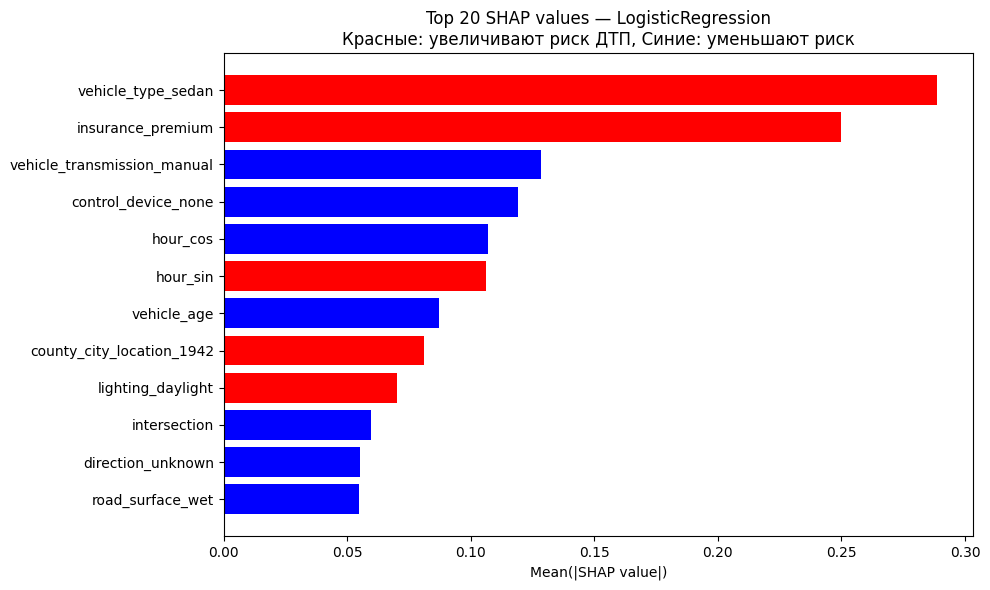

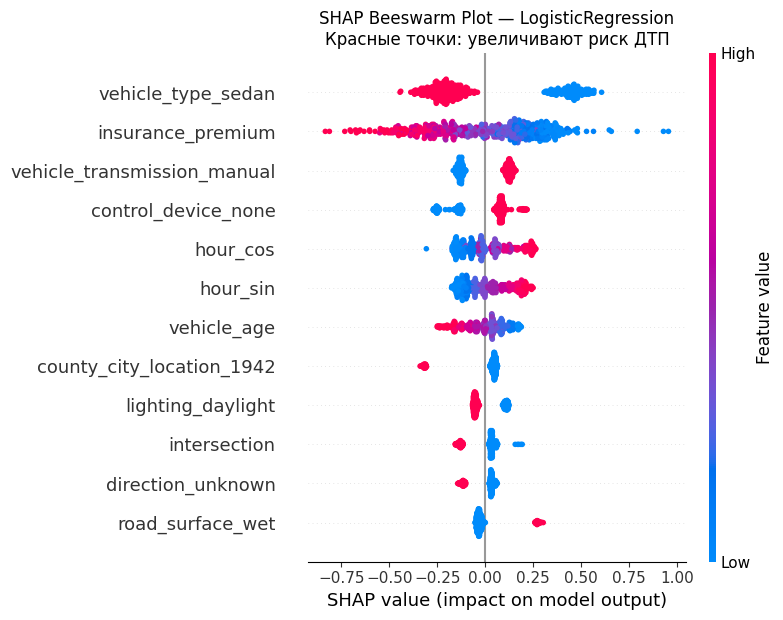

In [46]:
N = 20

classifier = list(best_model.named_steps.values())[-1]

if hasattr(classifier, "feature_importances_"):
    feature_importance = (
        pd.DataFrame({"feature": selected_features,
                      "importance": classifier.feature_importances_})
        .sort_values("importance", ascending=False)
    )
elif hasattr(classifier, "coef_"):
    coefs = classifier.coef_[0]
    feature_importance = (
        pd.DataFrame({"feature": selected_features,
                      "importance": coefs})
        .sort_values("importance", key=np.abs, ascending=False)
    )
else:
    feature_importance = None

X_train_transformed = preprocessor.transform(X_train)
X_train_selected = selector.transform(X_train_transformed)
X_selected_df = pd.DataFrame(X_train_selected, columns=selected_features)

sample_size = min(500, len(X_selected_df))
if len(X_selected_df) > sample_size:
    idx = np.random.choice(len(X_selected_df), sample_size, replace=False)
    X_sample = X_selected_df.iloc[idx]
else:
    X_sample = X_selected_df

shap_values = None

model_type = best_model_name_cv

if model_type == "LogisticRegression":
    explainer = shap.LinearExplainer(classifier, X_sample, feature_perturbation="correlation_dependent")
    shap_values = explainer.shap_values(X_sample)
    
    if isinstance(shap_values, np.ndarray):
        shap_array = shap_values
    
elif model_type in ["RandomForest", "DecisionTree", "LightGBM"]:
    explainer = shap.TreeExplainer(classifier)
    shap_values_result = explainer.shap_values(X_sample)
    
    if isinstance(shap_values_result, list):
        shap_array = shap_values_result[1]
    else:
        shap_array = shap_values_result
        
    if hasattr(shap_array, 'values'):
        shap_array = shap_array.values
        
else:
    explainer = shap.KernelExplainer(classifier.predict_proba, X_sample.iloc[:100])
    shap_values_result = explainer.shap_values(X_sample, nsamples=100)
    
    if isinstance(shap_values_result, list):
        shap_array = shap_values_result[1]
    else:
        shap_array = shap_values_result

shap_array = np.asarray(shap_array)

if shap_array.ndim == 3:
    shap_array = shap_array[:, :, 1]

if shap_array.ndim == 1:
    shap_array = shap_array.reshape(-1, 1)

if shap_array.shape[1] != len(selected_features):
    logger.warning(f"Размер SHAP {shap_array.shape[1]} не совпадает с количеством признаков {len(selected_features)}")
    min_dim = min(shap_array.shape[1], len(selected_features))
    shap_array = shap_array[:, :min_dim]
    used_features = selected_features[:min_dim]
else:
    used_features = selected_features

mean_shap_by_feature = np.mean(shap_array, axis=0)
mean_abs_shap = np.mean(np.abs(shap_array), axis=0)

shap_df = (
    pd.DataFrame({
        "feature": used_features,
        "mean_shap": mean_shap_by_feature,
        "mean_abs_shap": mean_abs_shap
    })
    .sort_values("mean_abs_shap", ascending=False)
)

top_shap = shap_df.head(N)
top_list = top_shap["feature"].tolist()

plt.figure(figsize=(10, 6))
bar_colors = ['red' if v > 0 else 'blue' for v in top_shap["mean_shap"]]
plt.barh(top_shap["feature"][::-1], top_shap["mean_abs_shap"][::-1], color=bar_colors[::-1])
plt.title(f"Top {N} SHAP values — {model_type}\nКрасные: увеличивают риск ДТП, Синие: уменьшают риск")
plt.xlabel("Mean(|SHAP value|)")
plt.tight_layout()
plt.show()

# Для beeswarm plot используем только топ признаки
top_indices = [list(used_features).index(f) for f in top_list]
shap_top = shap_array[:, top_indices]
X_top = X_sample[top_list]

plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_top,
    features=X_top,
    feature_names=top_list,
    plot_type="dot",
    show=False
)
plt.title(f"SHAP Beeswarm Plot — {model_type}\nКрасные точки: увеличивают риск ДТП")
plt.tight_layout()
plt.show()

### Выводы 

Основные факторы ДТП по степени влияния  

1) Тип транспортного средства  
Седаны - наиболее значимый фактор, увеличивающий риск ДТП  
Это может быть связано с их распространенностью в выборке и особенностями эксплуатации  

2) Страховые премии  
Высокие страховые взносы ассоциируются с снижением риска ДТП  
Вероятно, отражает более ответственное поведение водителей, готовых платить за страховку  

3) Временные факторы  
Время суток (циклические признаки hour_sin и hour_cos) - существенно влияет на риск  
Наибольшая опасность в утренние и вечерние часы пик (7-9 утра и 16-19 вечера)  
Пятница и суббота - дни с повышенной аварийностью  

4) Технические характеристики  
Механическая коробка передач - увеличивает риск ДТП  
Возможно связано с повышенной сложностью управления для некоторых водителей  

5) Дорожная инфраструктура  
Отсутствие контрольных устройств (светофоров, знаков) - повышает риск  
Перекрестки - зоны повышенной опасности  
Конкретные локации (county_city_location_1942) - выявлены особо аварийные участки  

6) Погодные и дорожные условия  
Облачная погода и дождь - умеренно увеличивают риск  
Мокрое и заснеженное покрытие - ухудшают сцепление и повышают опасность  
Ночное время с уличным освещением - фактор риска, вероятно из-за ослабления внимания  

7) Освещение  
Дневное освещение - снижает риск ДТП  
Темное время суток с освещением - увеличивает риск  

8) Сезонные закономерности  
Летний период - пик аварийности (цикличность)  
Зимне-весенний переход - второй пик, связанный с изменением дорожных условий  

## Доп исследование одного из факторов

Для одного из выявленных важных факторов проведите дополнительное исследование:  
Покажите график зависимости фактора и целевой переменной.  
Предложите, чем можно оборудовать автомобиль, чтобы учесть этот фактор во время посадки водителя.  

После изучения модели - стоимость платежей по страховки является самым важным фактором влияющим на возникновение ДТП.

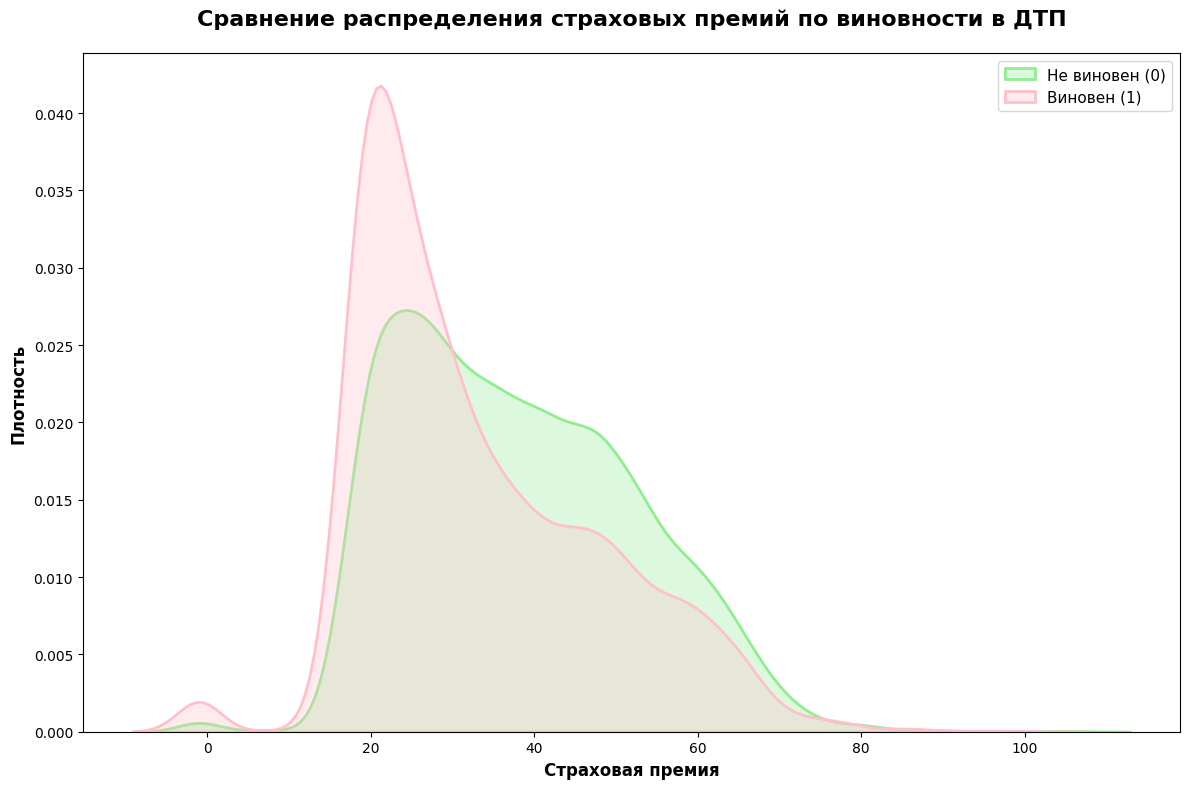

In [47]:
# график по количеству дтп к стоимости страховки
plt.figure(figsize=(12, 8))

sns.kdeplot(data=df_test[df_test['at_fault'] == 0], x='insurance_premium',
            color='lightgreen', fill=True, label='Не виновен (0)', 
            alpha=0.3, linewidth=2)

sns.kdeplot(data=df_test[df_test['at_fault'] == 1], x='insurance_premium',
            color='pink', fill=True, label='Виновен (1)',
            alpha=0.3, linewidth=2)

plt.title('Сравнение распределения страховых премий по виновности в ДТП', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Страховая премия', fontsize=12, fontweight='bold')
plt.ylabel('Плотность', fontsize=12, fontweight='bold')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

### Выводы

По графику мы видим, что больше всего ДТП с теми автомобилям, где небольшая страховая премия.  
Как только страховая премия начинает расти - риск возникновения ДТП по вине водителя каршеринга значительно падает.  
А вот плоность показывает, что разница незначительная, всего в 1 единцу.  

Здесь можно сделать несколько дополнительных выводов:  
1) Чем больше страховка тем дороже автомобиль тем более ответственно ведет себя водитель на дороге;  
2) Вторая сторона - потенциальный виновник может на подсознательном уровне выбрать автомобиль визуально дешевле, чтобы "въехать" в него.  

Исходя из всего вышеозвученного можно предложить следующее:  
1) Поднять стоимость страховок за каждое авто - следует провести а/б тест на предмет того, не упадет ли из-за этого спрос на авто у фирмы, т.к. явно подрастет цена услуг;  
2) Пополнить автопарк более премиальными авто с соответствующей страховкой.

И, предположу, что будет правильным доверится модели - которая по shap выявила стоимость страховки как 1 из самых важных признаков, что это действительно важно, не смотря, что второй график показывает обратное.

# Выводы о проделанной работе

На основе комплексного анализа данных о ДТП за 2012 год и построения прогнозной модели были выявлены ключевые факторы, влияющие на вероятность дорожно-транспортных происшествий.  

Исследование включало:  
Тщательный отбор данных - фильтрация по типу виновника (автомобили), серьезности повреждений (исключая царапины) и временному периоду  
Анализ и преобразование признаков - исключение признаков-утечек, создание циклических временных признаков, обработка пропусков  
Построение и сравнение моделей - тестирование алгоритмов машинного обучения с оптимизацией гиперпараметров  
Интерпретацию результатов - использование SHAP-анализа для определения влияния факторов на риск ДТП  
Лучшие результаты показала модель LogisticRegression с F1-мерой около 0.6, что свидетельствует о достаточной предсказательной способности для выявления основных закономерностей.  

Основные факторы ДТП по степени влияния  
1. Тип транспортного средства  
Седаны - наиболее значимый фактор, увеличивающий риск ДТП  
Это может быть связано с их распространенностью в выборке и особенностями эксплуатации  

2. Страховые премии  
Высокие страховые взносы ассоциируются с снижением риска ДТП  
Вероятно, отражает более ответственное поведение водителей, готовых платить за страховку  

3. Временные факторы  
Время суток (циклические признаки hour_sin и hour_cos) - существенно влияет на риск  
Наибольшая опасность в утренние и вечерние часы пик (7-9 утра и 16-19 вечера)  
Пятница и суббота - дни с повышенной аварийностью  

4. Технические характеристики  
Механическая коробка передач - увеличивает риск ДТП  
Возможно связано с повышенной сложностью управления для некоторых водителей  

5. Дорожная инфраструктура  
Отсутствие контрольных устройств (светофоров, знаков) - повышает риск  
Перекрестки - зоны повышенной опасности  
Конкретные локации (county_city_location_1942) - выявлены особо аварийные участки  

6. Погодные и дорожные условия  
Облачная погода и дождь - умеренно увеличивают риск  
Мокрое и заснеженное покрытие - ухудшают сцепление и повышают опасность  
Ночное время с уличным освещением - фактор риска, вероятно из-за ослабления внимания  

7. Освещение  
Дневное освещение - снижает риск ДТП  
Темное время суток с освещением - увеличивает риск  

Сезонные закономерности
- Летний период - пик аварийности (цикличность)  
- Зимне-весенний переход - второй пик, связанный с изменением дорожных условий  

Практические рекомендации  
Для водителей:  
- Повысить внимательность в часы пик и в пятницу-субботу  
- Особую осторожность проявлять при управлении седанами с МКПП  
- Учитывать погодные условия и состояние дорожного покрытия  

Для городских служб:  
- Усилить контроль на выявленных аварийных участках (например, location_1942)  
- Рассмотреть установку дополнительных контрольных устройств в опасных зонах  
- Улучшить освещение и дорожное покрытие в проблемных локациях  

Для страховых компаний:  
- Учитывать выявленные факторы при расчете страховых премий  
- Разработать программы поощрения для водителей с низким уровнем риска  

Модель демонстрирует, что риск ДТП определяется комплексным взаимодействием технических, временных, географических и погодных факторов, что требует системного подхода к профилактике дорожно-транспортных происшествий.